In [1]:
import torch
import glob
import tqdm

import matplotlib.pyplot as plt
import numpy as np
import torch.nn as nn
import torch.nn.functional as F

from utilities import utils, train_utils
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import normalize
from torch.utils.data import DataLoader, TensorDataset, Dataset
from pythae.models import AE, AEConfig
from pythae.trainers import BaseTrainerConfig
from pythae.pipelines.training import TrainingPipeline
from pythae.models.nn import BaseEncoder, BaseDecoder
from pythae.models.base.base_utils import ModelOutput

In [2]:
# for testing: copy a (1, 768) vector 77 times to create (77, 768)
class CustomDataset(Dataset):
    def __init__(self, data):
        self.data = data

    def __len__(self):
        return len(self.data)
    
    def __getitem__(self, idx):
        sample = self.data[idx][0].repeat(77, 1)
        sample = sample.unsqueeze(0)

        return sample

In [3]:
paths = sorted(glob.glob('./data/environmental_embeddings_0001/0001/*.msgpack'))
device = train_utils.get_device()

X = []
for path in tqdm.tqdm(paths):
    pos_emb, neg_emb = utils.read_embedding_data(path)
    X.append(pos_emb)
X = np.concatenate(X, axis=0)

# reshape to 2D to apply L2 normalization
X = X.reshape(-1, 768)
X, l2_norm = normalize(X, norm='l2', axis=1, return_norm=True)

# reshape it back
X = X.reshape(-1, 77, 768)

Xtr, Xvl = train_test_split(X, test_size=0.2, random_state=42)

train_data = torch.tensor(Xtr, dtype=torch.float32)
val_data = torch.tensor(Xvl, dtype=torch.float32)

train_dataset = TensorDataset(train_data)
val_dataset = TensorDataset(val_data)
# train_dataset = CustomDataset(train_data)
# val_dataset = CustomDataset(val_data)

  2%|▏         | 19/1000 [00:00<00:05, 181.47it/s]

100%|██████████| 1000/1000 [00:05<00:00, 197.57it/s]


In [4]:
class Encoder(nn.Module):
    def __init__(self, input_dim, latent_dim):
        super(Encoder, self).__init__()
        self.input_dim = input_dim
        self.latent_dim = latent_dim
        
        # define encoder layers: 3 layers fc of 1024, last fc no activation
        self.encoder_layers = nn.Sequential(
            nn.Linear(self.input_dim, 1024),
            nn.ReLU(),
            nn.Linear(1024, 1024),
            nn.ReLU(),
            nn.Linear(1024, 512),
            nn.ReLU(),
            nn.Linear(512, 512),
            nn.ReLU(),
        )

        self.fc_latent = nn.Linear(512, self.latent_dim)
        self.pooling = nn.MaxPool1d(kernel_size=77, stride=1)

    def forward(self, x):
        assert x.shape == (x.shape[0], 77, 768)

        # reshape for fc
        x = x.view(-1, 768)
        x = self.encoder_layers(x)

        # reshape back to batch_size * 77 x hidden size
        x = x.view(-1, 77, 512)
        x = self.pooling(x.permute(0, 2, 1)).squeeze(-1)
        x = self.fc_latent(x)

        return x
    
class Decoder(nn.Module):
    def __init__(self, input_dim, latent_dim):
        super(Decoder, self).__init__()
        self.input_dim = input_dim
        self.latent_dim = latent_dim

        # define decoder layers: 3 layers of fc 1024, last layer activated with tanh
        self.decoder_layers = nn.Sequential(
            nn.Linear(self.latent_dim, 1024),
            nn.ReLU(),
            nn.Linear(1024, 1024),
            nn.ReLU(),
            nn.Linear(1024, 2048),
            nn.ReLU(),
            nn.Linear(2048, 2048),
            nn.ReLU(),
            nn.Linear(2048, 77 * self.input_dim),
            nn.Tanh()
        )

    def forward(self, z):
        assert z.shape == (z.shape[0], self.latent_dim)

        x = self.decoder_layers(z)

        # reshape to batch_size * 77 * 768
        x = x.view(-1, 77, 768)

        return x
    
class AutoEncoder(nn.Module):
    def __init__(self, input_dim, latent_dim):
        super(AutoEncoder, self).__init__()

        self.encoder = Encoder(input_dim, latent_dim)
        self.decoder = Decoder(input_dim, latent_dim)

    def forward(self, x):
        self.z = self.encoder(x)
        recon = self.decoder(self.z)

        return recon

In [5]:
model = AutoEncoder(input_dim=768, latent_dim=256)
optimizer = torch.optim.AdamW(model.parameters(), lr=1e-4)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, patience=10, threshold=0.01)
model = model.to(device)
model

AutoEncoder(
  (encoder): Encoder(
    (encoder_layers): Sequential(
      (0): Linear(in_features=768, out_features=1024, bias=True)
      (1): ReLU()
      (2): Linear(in_features=1024, out_features=1024, bias=True)
      (3): ReLU()
      (4): Linear(in_features=1024, out_features=512, bias=True)
      (5): ReLU()
      (6): Linear(in_features=512, out_features=512, bias=True)
      (7): ReLU()
    )
    (fc_latent): Linear(in_features=512, out_features=256, bias=True)
    (pooling): MaxPool1d(kernel_size=77, stride=1, padding=0, dilation=1, ceil_mode=False)
  )
  (decoder): Decoder(
    (decoder_layers): Sequential(
      (0): Linear(in_features=256, out_features=1024, bias=True)
      (1): ReLU()
      (2): Linear(in_features=1024, out_features=1024, bias=True)
      (3): ReLU()
      (4): Linear(in_features=1024, out_features=2048, bias=True)
      (5): ReLU()
      (6): Linear(in_features=2048, out_features=2048, bias=True)
      (7): ReLU()
      (8): Linear(in_features=2048, o

In [6]:
save_path = 'experiments/fc_exp6/'
epoch = 800
batch_size = 128
sparsity_penalty_weight = 0

In [7]:
# loss function
class MSELossFC(nn.Module):
    def __init__(self, sparsity_penalty_weight=0.0):
        super(MSELossFC, self).__init__()
        self.sparsity_penalty_weight = sparsity_penalty_weight

    def forward(self, y, y_hat, z):
        assert y.shape == (y.shape[0], 77, 768)
        assert y_hat.shape == (y.shape[0], 77, 768)

        reconstruction_loss = nn.MSELoss(reduction='sum')(y, y_hat)
        
        l1_penalty = torch.abs(z).mean()
        sparsity_loss = l1_penalty * self.sparsity_penalty_weight

        total_loss = reconstruction_loss + sparsity_loss

        return total_loss

criterion = MSELossFC(sparsity_penalty_weight)

val loss: 66.653: 100%|██████████| 2/2 [00:00<00:00, 61.18it/s]


Weight saved: epoch 0
Epoch 0	Train Loss: 79.464  Val Loss: 66.589



val loss: 51.382: 100%|██████████| 2/2 [00:00<00:00, 65.76it/s]


Weight saved: epoch 1
Epoch 1	Train Loss: 58.460  Val Loss: 51.218



val loss: 45.886: 100%|██████████| 2/2 [00:00<00:00, 56.93it/s]


Weight saved: epoch 2
Epoch 2	Train Loss: 48.046  Val Loss: 45.749



val loss: 44.035: 100%|██████████| 2/2 [00:00<00:00, 65.58it/s]


Weight saved: epoch 3
Epoch 3	Train Loss: 44.948  Val Loss: 43.875



val loss: 43.154: 100%|██████████| 2/2 [00:00<00:00, 61.66it/s]


Weight saved: epoch 4
Epoch 4	Train Loss: 43.616  Val Loss: 43.004



val loss: 42.634: 100%|██████████| 2/2 [00:00<00:00, 62.31it/s]


Weight saved: epoch 5
Epoch 5	Train Loss: 42.868  Val Loss: 42.489



val loss: 42.345: 100%|██████████| 2/2 [00:00<00:00, 61.61it/s]


Weight saved: epoch 6
Epoch 6	Train Loss: 42.578  Val Loss: 42.205



val loss: 42.199: 100%|██████████| 2/2 [00:00<00:00, 64.48it/s]


Weight saved: epoch 7
Epoch 7	Train Loss: 42.319  Val Loss: 42.055



val loss: 42.109: 100%|██████████| 2/2 [00:00<00:00, 66.97it/s]


Weight saved: epoch 8
Epoch 8	Train Loss: 42.197  Val Loss: 41.968



val loss: 42.045: 100%|██████████| 2/2 [00:00<00:00, 65.73it/s]


Weight saved: epoch 9
Epoch 9	Train Loss: 42.136  Val Loss: 41.904



val loss: 41.996: 100%|██████████| 2/2 [00:00<00:00, 43.08it/s]


Weight saved: epoch 10
Epoch 10	Train Loss: 42.021  Val Loss: 41.862



val loss: 41.964: 100%|██████████| 2/2 [00:00<00:00, 64.32it/s]


Weight saved: epoch 11
Epoch 11	Train Loss: 42.109  Val Loss: 41.819



val loss: 41.950: 100%|██████████| 2/2 [00:00<00:00, 65.98it/s]


Weight saved: epoch 12
Epoch 12	Train Loss: 41.898  Val Loss: 41.808



val loss: 41.907: 100%|██████████| 2/2 [00:00<00:00, 66.29it/s]


Weight saved: epoch 13
Epoch 13	Train Loss: 42.022  Val Loss: 41.770



val loss: 41.934: 100%|██████████| 2/2 [00:00<00:00, 49.79it/s]


Epoch 14	Train Loss: 41.974  Val Loss: 41.782



val loss: 41.903: 100%|██████████| 2/2 [00:00<00:00, 65.15it/s]


Weight saved: epoch 15
Epoch 15	Train Loss: 41.892  Val Loss: 41.760



val loss: 41.887: 100%|██████████| 2/2 [00:00<00:00, 65.26it/s]


Weight saved: epoch 16
Epoch 16	Train Loss: 41.863  Val Loss: 41.741



val loss: 41.872: 100%|██████████| 2/2 [00:00<00:00, 66.50it/s]


Weight saved: epoch 17
Epoch 17	Train Loss: 41.785  Val Loss: 41.725



val loss: 41.869: 100%|██████████| 2/2 [00:00<00:00, 67.40it/s]


Weight saved: epoch 18
Epoch 18	Train Loss: 41.871  Val Loss: 41.720



val loss: 41.845: 100%|██████████| 2/2 [00:00<00:00, 63.42it/s]


Weight saved: epoch 19
Epoch 19	Train Loss: 41.870  Val Loss: 41.695



val loss: 41.842: 100%|██████████| 2/2 [00:00<00:00, 61.68it/s]


Weight saved: epoch 20
Epoch 20	Train Loss: 41.836  Val Loss: 41.687



val loss: 41.828: 100%|██████████| 2/2 [00:00<00:00, 63.76it/s]


Weight saved: epoch 21
Epoch 21	Train Loss: 41.816  Val Loss: 41.676



val loss: 41.767: 100%|██████████| 2/2 [00:00<00:00, 67.00it/s]


Weight saved: epoch 22
Epoch 22	Train Loss: 41.727  Val Loss: 41.611



val loss: 41.733: 100%|██████████| 2/2 [00:00<00:00, 65.41it/s]


Weight saved: epoch 23
Epoch 23	Train Loss: 41.628  Val Loss: 41.551



val loss: 41.641: 100%|██████████| 2/2 [00:00<00:00, 63.30it/s]


Weight saved: epoch 24
Epoch 24	Train Loss: 41.532  Val Loss: 41.454



val loss: 41.570: 100%|██████████| 2/2 [00:00<00:00, 65.82it/s]


Weight saved: epoch 25
Epoch 25	Train Loss: 41.367  Val Loss: 41.362



val loss: 41.533: 100%|██████████| 2/2 [00:00<00:00, 66.59it/s]


Weight saved: epoch 26
Epoch 26	Train Loss: 41.217  Val Loss: 41.320



val loss: 41.507: 100%|██████████| 2/2 [00:00<00:00, 62.73it/s]


Weight saved: epoch 27
Epoch 27	Train Loss: 41.166  Val Loss: 41.289



val loss: 41.477: 100%|██████████| 2/2 [00:00<00:00, 65.75it/s]


Weight saved: epoch 28
Epoch 28	Train Loss: 41.219  Val Loss: 41.265



val loss: 41.463: 100%|██████████| 2/2 [00:00<00:00, 52.98it/s]


Weight saved: epoch 29
Epoch 29	Train Loss: 41.185  Val Loss: 41.257



val loss: 41.438: 100%|██████████| 2/2 [00:00<00:00, 63.80it/s]


Weight saved: epoch 30
Epoch 30	Train Loss: 41.201  Val Loss: 41.233



val loss: 41.425: 100%|██████████| 2/2 [00:00<00:00, 65.33it/s]


Weight saved: epoch 31
Epoch 31	Train Loss: 41.100  Val Loss: 41.216



val loss: 41.391: 100%|██████████| 2/2 [00:00<00:00, 67.71it/s]


Weight saved: epoch 32
Epoch 32	Train Loss: 41.066  Val Loss: 41.179



val loss: 41.399: 100%|██████████| 2/2 [00:00<00:00, 61.94it/s]


Epoch 33	Train Loss: 41.112  Val Loss: 41.191



val loss: 41.405: 100%|██████████| 2/2 [00:00<00:00, 67.12it/s]


Epoch 34	Train Loss: 41.048  Val Loss: 41.184



val loss: 41.346: 100%|██████████| 2/2 [00:00<00:00, 56.63it/s]


Weight saved: epoch 35
Epoch 35	Train Loss: 40.952  Val Loss: 41.143



val loss: 41.350: 100%|██████████| 2/2 [00:00<00:00, 63.05it/s]


Weight saved: epoch 36
Epoch 36	Train Loss: 41.068  Val Loss: 41.138



val loss: 41.328: 100%|██████████| 2/2 [00:00<00:00, 67.17it/s]


Weight saved: epoch 37
Epoch 37	Train Loss: 40.987  Val Loss: 41.126



val loss: 41.276: 100%|██████████| 2/2 [00:00<00:00, 54.98it/s]


Weight saved: epoch 38
Epoch 38	Train Loss: 40.821  Val Loss: 41.079



val loss: 41.266: 100%|██████████| 2/2 [00:00<00:00, 62.70it/s]


Weight saved: epoch 39
Epoch 39	Train Loss: 40.798  Val Loss: 41.039



val loss: 41.200: 100%|██████████| 2/2 [00:00<00:00, 48.50it/s]


Weight saved: epoch 40
Epoch 40	Train Loss: 40.813  Val Loss: 40.995



val loss: 41.163: 100%|██████████| 2/2 [00:00<00:00, 65.10it/s]


Weight saved: epoch 41
Epoch 41	Train Loss: 40.753  Val Loss: 40.954



val loss: 41.139: 100%|██████████| 2/2 [00:00<00:00, 48.47it/s]


Weight saved: epoch 42
Epoch 42	Train Loss: 40.655  Val Loss: 40.925



val loss: 41.080: 100%|██████████| 2/2 [00:00<00:00, 65.50it/s]


Weight saved: epoch 43
Epoch 43	Train Loss: 40.575  Val Loss: 40.880



val loss: 41.044: 100%|██████████| 2/2 [00:00<00:00, 65.12it/s]


Weight saved: epoch 44
Epoch 44	Train Loss: 40.538  Val Loss: 40.854



val loss: 41.014: 100%|██████████| 2/2 [00:00<00:00, 53.31it/s]


Weight saved: epoch 45
Epoch 45	Train Loss: 40.518  Val Loss: 40.816



val loss: 40.980: 100%|██████████| 2/2 [00:00<00:00, 66.91it/s]


Weight saved: epoch 46
Epoch 46	Train Loss: 40.497  Val Loss: 40.795



val loss: 40.977: 100%|██████████| 2/2 [00:00<00:00, 48.52it/s]


Weight saved: epoch 47
Epoch 47	Train Loss: 40.402  Val Loss: 40.783



val loss: 40.986: 100%|██████████| 2/2 [00:00<00:00, 66.18it/s]


Epoch 48	Train Loss: 40.467  Val Loss: 40.803



val loss: 41.014: 100%|██████████| 2/2 [00:00<00:00, 67.71it/s]


Epoch 49	Train Loss: 40.344  Val Loss: 40.829



val loss: 40.938: 100%|██████████| 2/2 [00:00<00:00, 67.54it/s]


Weight saved: epoch 50
Epoch 50	Train Loss: 40.307  Val Loss: 40.766



val loss: 40.903: 100%|██████████| 2/2 [00:00<00:00, 62.59it/s]


Weight saved: epoch 51
Epoch 51	Train Loss: 40.357  Val Loss: 40.726



val loss: 40.947: 100%|██████████| 2/2 [00:00<00:00, 67.09it/s]


Epoch 52	Train Loss: 40.355  Val Loss: 40.776



val loss: 40.882: 100%|██████████| 2/2 [00:00<00:00, 62.23it/s]


Weight saved: epoch 53
Epoch 53	Train Loss: 40.278  Val Loss: 40.725



val loss: 40.946: 100%|██████████| 2/2 [00:00<00:00, 40.45it/s]


Epoch 54	Train Loss: 40.287  Val Loss: 40.798



val loss: 40.874: 100%|██████████| 2/2 [00:00<00:00, 66.72it/s]


Weight saved: epoch 55
Epoch 55	Train Loss: 40.251  Val Loss: 40.720



val loss: 40.871: 100%|██████████| 2/2 [00:00<00:00, 66.91it/s]


Weight saved: epoch 56
Epoch 56	Train Loss: 40.290  Val Loss: 40.705



val loss: 40.862: 100%|██████████| 2/2 [00:00<00:00, 63.62it/s]


Epoch 57	Train Loss: 40.280  Val Loss: 40.712



val loss: 40.872: 100%|██████████| 2/2 [00:00<00:00, 63.22it/s]


Epoch 58	Train Loss: 40.255  Val Loss: 40.731



val loss: 40.885: 100%|██████████| 2/2 [00:00<00:00, 65.95it/s]


Epoch 59	Train Loss: 40.226  Val Loss: 40.730



val loss: 40.851: 100%|██████████| 2/2 [00:00<00:00, 64.56it/s]


Epoch 60	Train Loss: 40.111  Val Loss: 40.706



val loss: 40.872: 100%|██████████| 2/2 [00:00<00:00, 55.49it/s]


Epoch 61	Train Loss: 40.206  Val Loss: 40.720



val loss: 40.885: 100%|██████████| 2/2 [00:00<00:00, 64.86it/s]


Epoch 62	Train Loss: 40.125  Val Loss: 40.729



val loss: 40.867: 100%|██████████| 2/2 [00:00<00:00, 62.55it/s]


Epoch 63	Train Loss: 40.107  Val Loss: 40.740



val loss: 40.831: 100%|██████████| 2/2 [00:00<00:00, 61.38it/s]


Weight saved: epoch 64
Epoch 64	Train Loss: 40.097  Val Loss: 40.691



val loss: 40.858: 100%|██████████| 2/2 [00:00<00:00, 66.97it/s]


Epoch 65	Train Loss: 40.070  Val Loss: 40.704



val loss: 40.847: 100%|██████████| 2/2 [00:00<00:00, 59.96it/s]


Epoch 66	Train Loss: 39.967  Val Loss: 40.705



val loss: 40.831: 100%|██████████| 2/2 [00:00<00:00, 61.72it/s]


Epoch 67	Train Loss: 39.943  Val Loss: 40.716



val loss: 40.842: 100%|██████████| 2/2 [00:00<00:00, 67.09it/s]


Epoch 68	Train Loss: 39.914  Val Loss: 40.704



val loss: 40.864: 100%|██████████| 2/2 [00:00<00:00, 63.25it/s]


Epoch 69	Train Loss: 39.999  Val Loss: 40.714



val loss: 40.837: 100%|██████████| 2/2 [00:00<00:00, 55.90it/s]


Epoch 70	Train Loss: 40.058  Val Loss: 40.691



val loss: 40.834: 100%|██████████| 2/2 [00:00<00:00, 63.61it/s]


Epoch 71	Train Loss: 39.915  Val Loss: 40.694



val loss: 40.828: 100%|██████████| 2/2 [00:00<00:00, 48.55it/s]


Epoch 72	Train Loss: 39.844  Val Loss: 40.707



val loss: 40.861: 100%|██████████| 2/2 [00:00<00:00, 62.06it/s]


Epoch 73	Train Loss: 39.884  Val Loss: 40.709



val loss: 40.843: 100%|██████████| 2/2 [00:00<00:00, 51.98it/s]


Epoch 74	Train Loss: 39.937  Val Loss: 40.706



val loss: 40.860: 100%|██████████| 2/2 [00:00<00:00, 64.98it/s]


Epoch 75	Train Loss: 39.906  Val Loss: 40.730



val loss: 40.841: 100%|██████████| 2/2 [00:00<00:00, 46.26it/s]


Epoch 76	Train Loss: 39.801  Val Loss: 40.703



val loss: 40.856: 100%|██████████| 2/2 [00:00<00:00, 66.09it/s]


Epoch 77	Train Loss: 39.858  Val Loss: 40.703



val loss: 40.857: 100%|██████████| 2/2 [00:00<00:00, 54.03it/s]


Epoch 78	Train Loss: 39.730  Val Loss: 40.703



val loss: 40.846: 100%|██████████| 2/2 [00:00<00:00, 62.32it/s]


Epoch 79	Train Loss: 39.725  Val Loss: 40.708



val loss: 40.827: 100%|██████████| 2/2 [00:00<00:00, 40.80it/s]


Weight saved: epoch 80
Epoch 80	Train Loss: 39.697  Val Loss: 40.685



val loss: 40.864: 100%|██████████| 2/2 [00:00<00:00, 66.34it/s]


Epoch 81	Train Loss: 39.822  Val Loss: 40.719



val loss: 40.850: 100%|██████████| 2/2 [00:00<00:00, 64.20it/s]


Epoch 82	Train Loss: 39.811  Val Loss: 40.703



val loss: 40.855: 100%|██████████| 2/2 [00:00<00:00, 48.05it/s]


Epoch 83	Train Loss: 39.721  Val Loss: 40.716



val loss: 40.879: 100%|██████████| 2/2 [00:00<00:00, 64.91it/s]


Epoch 84	Train Loss: 39.652  Val Loss: 40.741



val loss: 40.875: 100%|██████████| 2/2 [00:00<00:00, 65.16it/s]


Epoch 85	Train Loss: 39.678  Val Loss: 40.719



val loss: 40.861: 100%|██████████| 2/2 [00:00<00:00, 63.73it/s]


Epoch 86	Train Loss: 39.574  Val Loss: 40.709



val loss: 40.909: 100%|██████████| 2/2 [00:00<00:00, 66.33it/s]


Epoch 87	Train Loss: 39.768  Val Loss: 40.783



val loss: 40.922: 100%|██████████| 2/2 [00:00<00:00, 46.31it/s]


Epoch 88	Train Loss: 39.708  Val Loss: 40.772



val loss: 40.890: 100%|██████████| 2/2 [00:00<00:00, 63.09it/s]


Epoch 89	Train Loss: 39.797  Val Loss: 40.731



val loss: 40.908: 100%|██████████| 2/2 [00:00<00:00, 64.27it/s]


Epoch 90	Train Loss: 39.578  Val Loss: 40.756



val loss: 40.939: 100%|██████████| 2/2 [00:00<00:00, 63.04it/s]


Epoch 91	Train Loss: 39.663  Val Loss: 40.786



val loss: 40.882: 100%|██████████| 2/2 [00:00<00:00, 41.58it/s]


Epoch 92	Train Loss: 39.602  Val Loss: 40.730



val loss: 40.919: 100%|██████████| 2/2 [00:00<00:00, 65.44it/s]


Epoch 93	Train Loss: 39.616  Val Loss: 40.771



val loss: 40.891: 100%|██████████| 2/2 [00:00<00:00, 44.77it/s]


Epoch 94	Train Loss: 39.631  Val Loss: 40.741



val loss: 40.931: 100%|██████████| 2/2 [00:00<00:00, 63.44it/s]


Epoch 95	Train Loss: 39.620  Val Loss: 40.771



val loss: 40.902: 100%|██████████| 2/2 [00:00<00:00, 62.05it/s]


Epoch 96	Train Loss: 39.648  Val Loss: 40.756



val loss: 40.938: 100%|██████████| 2/2 [00:00<00:00, 63.99it/s]


Epoch 97	Train Loss: 39.618  Val Loss: 40.803



val loss: 40.922: 100%|██████████| 2/2 [00:00<00:00, 46.91it/s]


Epoch 98	Train Loss: 39.578  Val Loss: 40.766



val loss: 40.963: 100%|██████████| 2/2 [00:00<00:00, 63.08it/s]


Epoch 99	Train Loss: 39.521  Val Loss: 40.803



val loss: 40.952: 100%|██████████| 2/2 [00:00<00:00, 60.71it/s]


Epoch 100	Train Loss: 39.692  Val Loss: 40.799



val loss: 40.956: 100%|██████████| 2/2 [00:00<00:00, 51.46it/s]


Epoch 101	Train Loss: 39.609  Val Loss: 40.820



val loss: 40.992: 100%|██████████| 2/2 [00:00<00:00, 63.69it/s]


Epoch 102	Train Loss: 39.604  Val Loss: 40.832



val loss: 40.934: 100%|██████████| 2/2 [00:00<00:00, 63.10it/s]


Epoch 103	Train Loss: 39.442  Val Loss: 40.790



val loss: 40.973: 100%|██████████| 2/2 [00:00<00:00, 62.30it/s]


Epoch 104	Train Loss: 39.483  Val Loss: 40.817



val loss: 40.970: 100%|██████████| 2/2 [00:00<00:00, 59.61it/s]


Epoch 105	Train Loss: 39.448  Val Loss: 40.829



val loss: 40.958: 100%|██████████| 2/2 [00:00<00:00, 59.75it/s]


Epoch 106	Train Loss: 39.391  Val Loss: 40.803



val loss: 40.976: 100%|██████████| 2/2 [00:00<00:00, 62.54it/s]


Epoch 107	Train Loss: 39.337  Val Loss: 40.828



val loss: 40.981: 100%|██████████| 2/2 [00:00<00:00, 46.21it/s]


Epoch 108	Train Loss: 39.465  Val Loss: 40.821



val loss: 40.984: 100%|██████████| 2/2 [00:00<00:00, 60.70it/s]


Epoch 109	Train Loss: 39.425  Val Loss: 40.825



val loss: 40.949: 100%|██████████| 2/2 [00:00<00:00, 60.10it/s]


Epoch 110	Train Loss: 39.457  Val Loss: 40.808



val loss: 40.981: 100%|██████████| 2/2 [00:00<00:00, 60.34it/s]


Epoch 111	Train Loss: 39.427  Val Loss: 40.830



val loss: 40.983: 100%|██████████| 2/2 [00:00<00:00, 63.49it/s]


Epoch 112	Train Loss: 39.504  Val Loss: 40.832



val loss: 41.016: 100%|██████████| 2/2 [00:00<00:00, 61.60it/s]


Epoch 113	Train Loss: 39.334  Val Loss: 40.852



val loss: 40.977: 100%|██████████| 2/2 [00:00<00:00, 62.08it/s]


Epoch 114	Train Loss: 39.333  Val Loss: 40.827



val loss: 41.053: 100%|██████████| 2/2 [00:00<00:00, 60.51it/s]


Epoch 115	Train Loss: 39.373  Val Loss: 40.905



val loss: 41.025: 100%|██████████| 2/2 [00:00<00:00, 53.69it/s]


Epoch 116	Train Loss: 39.314  Val Loss: 40.862



val loss: 41.059: 100%|██████████| 2/2 [00:00<00:00, 62.58it/s]


Epoch 117	Train Loss: 39.250  Val Loss: 40.894



val loss: 41.015: 100%|██████████| 2/2 [00:00<00:00, 66.98it/s]


Epoch 118	Train Loss: 39.232  Val Loss: 40.861



val loss: 41.017: 100%|██████████| 2/2 [00:00<00:00, 67.01it/s]


Epoch 119	Train Loss: 39.318  Val Loss: 40.863



val loss: 41.013: 100%|██████████| 2/2 [00:00<00:00, 63.59it/s]


Epoch 120	Train Loss: 39.215  Val Loss: 40.855



val loss: 41.062: 100%|██████████| 2/2 [00:00<00:00, 64.23it/s]


Epoch 121	Train Loss: 39.224  Val Loss: 40.902



val loss: 41.027: 100%|██████████| 2/2 [00:00<00:00, 63.15it/s]


Epoch 122	Train Loss: 39.217  Val Loss: 40.863



val loss: 41.036: 100%|██████████| 2/2 [00:00<00:00, 62.76it/s]


Epoch 123	Train Loss: 39.235  Val Loss: 40.881



val loss: 41.048: 100%|██████████| 2/2 [00:00<00:00, 63.05it/s]


Epoch 124	Train Loss: 39.322  Val Loss: 40.886



val loss: 41.042: 100%|██████████| 2/2 [00:00<00:00, 57.37it/s]


Epoch 125	Train Loss: 39.280  Val Loss: 40.876



val loss: 41.072: 100%|██████████| 2/2 [00:00<00:00, 64.00it/s]


Epoch 126	Train Loss: 39.137  Val Loss: 40.904



val loss: 41.062: 100%|██████████| 2/2 [00:00<00:00, 64.93it/s]


Epoch 127	Train Loss: 39.113  Val Loss: 40.893



val loss: 41.063: 100%|██████████| 2/2 [00:00<00:00, 62.54it/s]


Epoch 128	Train Loss: 39.033  Val Loss: 40.902



val loss: 41.069: 100%|██████████| 2/2 [00:00<00:00, 67.28it/s]


Epoch 129	Train Loss: 39.145  Val Loss: 40.898



val loss: 41.099: 100%|██████████| 2/2 [00:00<00:00, 49.03it/s]


Epoch 130	Train Loss: 39.082  Val Loss: 40.928



val loss: 41.060: 100%|██████████| 2/2 [00:00<00:00, 64.46it/s]


Epoch 131	Train Loss: 39.088  Val Loss: 40.901



val loss: 41.084: 100%|██████████| 2/2 [00:00<00:00, 66.08it/s]


Epoch 132	Train Loss: 39.060  Val Loss: 40.915



val loss: 41.073: 100%|██████████| 2/2 [00:00<00:00, 67.29it/s]


Epoch 133	Train Loss: 39.173  Val Loss: 40.903



val loss: 41.126: 100%|██████████| 2/2 [00:00<00:00, 60.95it/s]


Epoch 134	Train Loss: 39.119  Val Loss: 40.963



val loss: 41.158: 100%|██████████| 2/2 [00:00<00:00, 63.27it/s]


Epoch 135	Train Loss: 39.109  Val Loss: 40.977



val loss: 41.159: 100%|██████████| 2/2 [00:00<00:00, 64.89it/s]


Epoch 136	Train Loss: 39.041  Val Loss: 40.986



val loss: 41.111: 100%|██████████| 2/2 [00:00<00:00, 62.08it/s]


Epoch 137	Train Loss: 39.074  Val Loss: 40.938



val loss: 41.111: 100%|██████████| 2/2 [00:00<00:00, 48.43it/s]


Epoch 138	Train Loss: 39.050  Val Loss: 40.934



val loss: 41.128: 100%|██████████| 2/2 [00:00<00:00, 66.07it/s]


Epoch 139	Train Loss: 39.153  Val Loss: 40.957



val loss: 41.117: 100%|██████████| 2/2 [00:00<00:00, 62.18it/s]


Epoch 140	Train Loss: 38.985  Val Loss: 40.934



val loss: 41.152: 100%|██████████| 2/2 [00:00<00:00, 66.98it/s]


Epoch 141	Train Loss: 38.953  Val Loss: 40.971



val loss: 41.161: 100%|██████████| 2/2 [00:00<00:00, 63.96it/s]


Epoch 142	Train Loss: 38.951  Val Loss: 40.986



val loss: 41.202: 100%|██████████| 2/2 [00:00<00:00, 65.82it/s]


Epoch 143	Train Loss: 39.002  Val Loss: 41.025



val loss: 41.191: 100%|██████████| 2/2 [00:00<00:00, 61.69it/s]


Epoch 144	Train Loss: 38.996  Val Loss: 41.004



val loss: 41.200: 100%|██████████| 2/2 [00:00<00:00, 50.73it/s]


Epoch 145	Train Loss: 38.930  Val Loss: 41.028



val loss: 41.171: 100%|██████████| 2/2 [00:00<00:00, 53.50it/s]


Epoch 146	Train Loss: 38.912  Val Loss: 40.994



val loss: 41.168: 100%|██████████| 2/2 [00:00<00:00, 64.84it/s]


Epoch 147	Train Loss: 38.768  Val Loss: 40.992



val loss: 41.195: 100%|██████████| 2/2 [00:00<00:00, 61.11it/s]


Epoch 148	Train Loss: 38.838  Val Loss: 41.002



val loss: 41.179: 100%|██████████| 2/2 [00:00<00:00, 62.84it/s]


Epoch 149	Train Loss: 38.917  Val Loss: 40.990



val loss: 41.190: 100%|██████████| 2/2 [00:00<00:00, 43.12it/s]


Epoch 150	Train Loss: 38.923  Val Loss: 41.002



val loss: 41.227: 100%|██████████| 2/2 [00:00<00:00, 62.83it/s]


Epoch 151	Train Loss: 38.911  Val Loss: 41.047



val loss: 41.282: 100%|██████████| 2/2 [00:00<00:00, 55.57it/s]


Epoch 152	Train Loss: 38.971  Val Loss: 41.097



val loss: 41.210: 100%|██████████| 2/2 [00:00<00:00, 66.90it/s]


Epoch 153	Train Loss: 38.954  Val Loss: 41.023



val loss: 41.224: 100%|██████████| 2/2 [00:00<00:00, 59.29it/s]


Epoch 154	Train Loss: 38.915  Val Loss: 41.049



val loss: 41.227: 100%|██████████| 2/2 [00:00<00:00, 64.34it/s]


Epoch 155	Train Loss: 38.751  Val Loss: 41.028



val loss: 41.219: 100%|██████████| 2/2 [00:00<00:00, 67.13it/s]


Epoch 156	Train Loss: 38.778  Val Loss: 41.025



val loss: 41.223: 100%|██████████| 2/2 [00:00<00:00, 65.22it/s]


Epoch 157	Train Loss: 38.748  Val Loss: 41.026



val loss: 41.282: 100%|██████████| 2/2 [00:00<00:00, 69.58it/s]


Epoch 158	Train Loss: 38.768  Val Loss: 41.074



val loss: 41.255: 100%|██████████| 2/2 [00:00<00:00, 68.37it/s]


Epoch 159	Train Loss: 38.760  Val Loss: 41.054



val loss: 41.229: 100%|██████████| 2/2 [00:00<00:00, 63.18it/s]


Epoch 160	Train Loss: 38.687  Val Loss: 41.046



val loss: 41.258: 100%|██████████| 2/2 [00:00<00:00, 68.59it/s]


Epoch 161	Train Loss: 38.489  Val Loss: 41.055



val loss: 41.228: 100%|██████████| 2/2 [00:00<00:00, 68.90it/s]


Epoch 162	Train Loss: 38.648  Val Loss: 41.020



val loss: 41.235: 100%|██████████| 2/2 [00:00<00:00, 68.67it/s]


Epoch 163	Train Loss: 38.702  Val Loss: 41.029



val loss: 41.206: 100%|██████████| 2/2 [00:00<00:00, 69.38it/s]


Epoch 164	Train Loss: 38.656  Val Loss: 41.005



val loss: 41.207: 100%|██████████| 2/2 [00:00<00:00, 51.39it/s]


Epoch 165	Train Loss: 38.449  Val Loss: 41.016



val loss: 41.166: 100%|██████████| 2/2 [00:00<00:00, 69.91it/s]


Epoch 166	Train Loss: 38.537  Val Loss: 40.974



val loss: 41.162: 100%|██████████| 2/2 [00:00<00:00, 67.36it/s]


Epoch 167	Train Loss: 38.513  Val Loss: 40.952



val loss: 41.160: 100%|██████████| 2/2 [00:00<00:00, 62.93it/s]


Epoch 168	Train Loss: 38.624  Val Loss: 40.952



val loss: 41.161: 100%|██████████| 2/2 [00:00<00:00, 68.40it/s]


Epoch 169	Train Loss: 38.412  Val Loss: 40.959



val loss: 41.154: 100%|██████████| 2/2 [00:00<00:00, 69.03it/s]


Epoch 170	Train Loss: 38.369  Val Loss: 40.941



val loss: 41.135: 100%|██████████| 2/2 [00:00<00:00, 58.79it/s]


Epoch 171	Train Loss: 38.499  Val Loss: 40.928



val loss: 41.132: 100%|██████████| 2/2 [00:00<00:00, 68.52it/s]


Epoch 172	Train Loss: 38.447  Val Loss: 40.915



val loss: 41.134: 100%|██████████| 2/2 [00:00<00:00, 53.69it/s]


Epoch 173	Train Loss: 38.398  Val Loss: 40.930



val loss: 41.136: 100%|██████████| 2/2 [00:00<00:00, 69.42it/s]


Epoch 174	Train Loss: 38.152  Val Loss: 40.907



val loss: 41.126: 100%|██████████| 2/2 [00:00<00:00, 67.27it/s]


Epoch 175	Train Loss: 38.259  Val Loss: 40.898



val loss: 41.130: 100%|██████████| 2/2 [00:00<00:00, 57.88it/s]


Epoch 176	Train Loss: 38.220  Val Loss: 40.897



val loss: 41.105: 100%|██████████| 2/2 [00:00<00:00, 69.02it/s]


Epoch 177	Train Loss: 38.308  Val Loss: 40.877



val loss: 41.105: 100%|██████████| 2/2 [00:00<00:00, 54.69it/s]


Epoch 178	Train Loss: 38.236  Val Loss: 40.883



val loss: 41.132: 100%|██████████| 2/2 [00:00<00:00, 68.75it/s]


Epoch 179	Train Loss: 38.119  Val Loss: 40.907



val loss: 41.091: 100%|██████████| 2/2 [00:00<00:00, 49.63it/s]


Epoch 180	Train Loss: 38.136  Val Loss: 40.860



val loss: 41.085: 100%|██████████| 2/2 [00:00<00:00, 68.84it/s]


Epoch 181	Train Loss: 38.183  Val Loss: 40.838



val loss: 41.154: 100%|██████████| 2/2 [00:00<00:00, 67.55it/s]


Epoch 182	Train Loss: 38.169  Val Loss: 40.912



val loss: 41.094: 100%|██████████| 2/2 [00:00<00:00, 67.96it/s]


Epoch 183	Train Loss: 38.009  Val Loss: 40.862



val loss: 41.089: 100%|██████████| 2/2 [00:00<00:00, 48.67it/s]


Epoch 184	Train Loss: 38.077  Val Loss: 40.860



val loss: 41.064: 100%|██████████| 2/2 [00:00<00:00, 68.56it/s]


Epoch 185	Train Loss: 38.053  Val Loss: 40.823



val loss: 41.070: 100%|██████████| 2/2 [00:00<00:00, 62.45it/s]


Epoch 186	Train Loss: 38.054  Val Loss: 40.821



val loss: 41.087: 100%|██████████| 2/2 [00:00<00:00, 69.52it/s]


Epoch 187	Train Loss: 37.883  Val Loss: 40.842



val loss: 41.086: 100%|██████████| 2/2 [00:00<00:00, 64.24it/s]


Epoch 188	Train Loss: 37.957  Val Loss: 40.844



val loss: 41.086: 100%|██████████| 2/2 [00:00<00:00, 67.98it/s]


Epoch 189	Train Loss: 37.967  Val Loss: 40.838



val loss: 41.144: 100%|██████████| 2/2 [00:00<00:00, 67.76it/s]


Epoch 190	Train Loss: 37.992  Val Loss: 40.881



val loss: 41.085: 100%|██████████| 2/2 [00:00<00:00, 57.22it/s]


Epoch 191	Train Loss: 37.908  Val Loss: 40.831



val loss: 41.107: 100%|██████████| 2/2 [00:00<00:00, 62.70it/s]


Epoch 192	Train Loss: 38.010  Val Loss: 40.853



val loss: 41.190: 100%|██████████| 2/2 [00:00<00:00, 53.37it/s]


Epoch 193	Train Loss: 37.925  Val Loss: 40.927



val loss: 41.103: 100%|██████████| 2/2 [00:00<00:00, 67.38it/s]


Epoch 194	Train Loss: 37.762  Val Loss: 40.846



val loss: 41.119: 100%|██████████| 2/2 [00:00<00:00, 59.89it/s]


Epoch 195	Train Loss: 37.838  Val Loss: 40.859



val loss: 41.178: 100%|██████████| 2/2 [00:00<00:00, 47.38it/s]


Epoch 196	Train Loss: 37.991  Val Loss: 40.934



val loss: 41.121: 100%|██████████| 2/2 [00:00<00:00, 61.49it/s]


Epoch 197	Train Loss: 37.869  Val Loss: 40.860



val loss: 41.163: 100%|██████████| 2/2 [00:00<00:00, 42.93it/s]


Epoch 198	Train Loss: 37.913  Val Loss: 40.897



val loss: 41.186: 100%|██████████| 2/2 [00:00<00:00, 59.57it/s]


Epoch 199	Train Loss: 37.833  Val Loss: 40.905



val loss: 41.180: 100%|██████████| 2/2 [00:00<00:00, 62.61it/s]


Epoch 200	Train Loss: 37.703  Val Loss: 40.906



val loss: 41.182: 100%|██████████| 2/2 [00:00<00:00, 63.60it/s]


Epoch 201	Train Loss: 37.789  Val Loss: 40.932



val loss: 41.285: 100%|██████████| 2/2 [00:00<00:00, 63.32it/s]


Epoch 202	Train Loss: 37.723  Val Loss: 41.025



val loss: 41.423: 100%|██████████| 2/2 [00:00<00:00, 63.13it/s]


Epoch 203	Train Loss: 37.933  Val Loss: 41.144



val loss: 41.263: 100%|██████████| 2/2 [00:00<00:00, 43.74it/s]


Epoch 204	Train Loss: 37.915  Val Loss: 40.977



val loss: 41.149: 100%|██████████| 2/2 [00:00<00:00, 64.06it/s]


Epoch 205	Train Loss: 37.801  Val Loss: 40.903



val loss: 41.199: 100%|██████████| 2/2 [00:00<00:00, 49.29it/s]


Epoch 206	Train Loss: 37.708  Val Loss: 40.930



val loss: 41.249: 100%|██████████| 2/2 [00:00<00:00, 62.85it/s]


Epoch 207	Train Loss: 37.788  Val Loss: 40.978



val loss: 41.217: 100%|██████████| 2/2 [00:00<00:00, 63.40it/s]


Epoch 208	Train Loss: 37.719  Val Loss: 40.937



val loss: 41.211: 100%|██████████| 2/2 [00:00<00:00, 63.33it/s]


Epoch 209	Train Loss: 37.735  Val Loss: 40.920



val loss: 41.217: 100%|██████████| 2/2 [00:00<00:00, 64.87it/s]


Epoch 210	Train Loss: 37.709  Val Loss: 40.944



val loss: 41.215: 100%|██████████| 2/2 [00:00<00:00, 54.09it/s]


Epoch 211	Train Loss: 37.630  Val Loss: 40.932



val loss: 41.214: 100%|██████████| 2/2 [00:00<00:00, 65.52it/s]


Epoch 212	Train Loss: 37.648  Val Loss: 40.938



val loss: 41.246: 100%|██████████| 2/2 [00:00<00:00, 62.14it/s]


Epoch 213	Train Loss: 37.678  Val Loss: 40.971



val loss: 41.235: 100%|██████████| 2/2 [00:00<00:00, 67.03it/s]


Epoch 214	Train Loss: 37.589  Val Loss: 40.961



val loss: 41.248: 100%|██████████| 2/2 [00:00<00:00, 65.01it/s]


Epoch 215	Train Loss: 37.503  Val Loss: 40.971



val loss: 41.244: 100%|██████████| 2/2 [00:00<00:00, 47.32it/s]


Epoch 216	Train Loss: 37.530  Val Loss: 40.956



val loss: 41.255: 100%|██████████| 2/2 [00:00<00:00, 62.73it/s]


Epoch 217	Train Loss: 37.602  Val Loss: 40.971



val loss: 41.269: 100%|██████████| 2/2 [00:00<00:00, 65.73it/s]


Epoch 218	Train Loss: 37.524  Val Loss: 40.996



val loss: 41.265: 100%|██████████| 2/2 [00:00<00:00, 62.42it/s]


Epoch 219	Train Loss: 37.570  Val Loss: 40.998



val loss: 41.307: 100%|██████████| 2/2 [00:00<00:00, 59.68it/s]


Epoch 220	Train Loss: 37.541  Val Loss: 41.024



val loss: 41.263: 100%|██████████| 2/2 [00:00<00:00, 44.56it/s]


Epoch 221	Train Loss: 37.585  Val Loss: 40.981



val loss: 41.306: 100%|██████████| 2/2 [00:00<00:00, 60.58it/s]


Epoch 222	Train Loss: 37.547  Val Loss: 41.032



val loss: 41.292: 100%|██████████| 2/2 [00:00<00:00, 62.25it/s]


Epoch 223	Train Loss: 37.474  Val Loss: 41.015



val loss: 41.282: 100%|██████████| 2/2 [00:00<00:00, 63.49it/s]


Epoch 224	Train Loss: 37.546  Val Loss: 40.997



val loss: 41.325: 100%|██████████| 2/2 [00:00<00:00, 58.36it/s]


Epoch 225	Train Loss: 37.416  Val Loss: 41.038



val loss: 41.312: 100%|██████████| 2/2 [00:00<00:00, 60.93it/s]


Epoch 226	Train Loss: 37.501  Val Loss: 41.026



val loss: 41.330: 100%|██████████| 2/2 [00:00<00:00, 61.10it/s]


Epoch 227	Train Loss: 37.411  Val Loss: 41.066



val loss: 41.339: 100%|██████████| 2/2 [00:00<00:00, 63.31it/s]


Epoch 228	Train Loss: 37.452  Val Loss: 41.048



val loss: 41.338: 100%|██████████| 2/2 [00:00<00:00, 59.58it/s]


Epoch 229	Train Loss: 37.479  Val Loss: 41.059



val loss: 41.345: 100%|██████████| 2/2 [00:00<00:00, 45.95it/s]


Epoch 230	Train Loss: 37.504  Val Loss: 41.057



val loss: 41.397: 100%|██████████| 2/2 [00:00<00:00, 59.44it/s]


Epoch 231	Train Loss: 37.410  Val Loss: 41.112



val loss: 41.382: 100%|██████████| 2/2 [00:00<00:00, 57.30it/s]


Epoch 232	Train Loss: 37.485  Val Loss: 41.102



val loss: 41.371: 100%|██████████| 2/2 [00:00<00:00, 50.90it/s]


Epoch 233	Train Loss: 37.435  Val Loss: 41.085



val loss: 41.372: 100%|██████████| 2/2 [00:00<00:00, 64.83it/s]


Epoch 234	Train Loss: 37.459  Val Loss: 41.073



val loss: 41.415: 100%|██████████| 2/2 [00:00<00:00, 63.87it/s]


Epoch 235	Train Loss: 37.371  Val Loss: 41.129



val loss: 41.383: 100%|██████████| 2/2 [00:00<00:00, 56.42it/s]


Epoch 236	Train Loss: 37.462  Val Loss: 41.092



val loss: 41.394: 100%|██████████| 2/2 [00:00<00:00, 63.92it/s]


Epoch 237	Train Loss: 37.304  Val Loss: 41.108



val loss: 41.386: 100%|██████████| 2/2 [00:00<00:00, 59.78it/s]


Epoch 238	Train Loss: 37.369  Val Loss: 41.097



val loss: 41.389: 100%|██████████| 2/2 [00:00<00:00, 63.50it/s]


Epoch 239	Train Loss: 37.380  Val Loss: 41.096



val loss: 41.523: 100%|██████████| 2/2 [00:00<00:00, 67.19it/s]


Epoch 240	Train Loss: 37.324  Val Loss: 41.225



val loss: 41.589: 100%|██████████| 2/2 [00:00<00:00, 63.86it/s]


Epoch 241	Train Loss: 37.266  Val Loss: 41.306



val loss: 41.520: 100%|██████████| 2/2 [00:00<00:00, 44.24it/s]


Epoch 242	Train Loss: 37.340  Val Loss: 41.228



val loss: 41.474: 100%|██████████| 2/2 [00:00<00:00, 61.27it/s]


Epoch 243	Train Loss: 37.342  Val Loss: 41.182



val loss: 41.441: 100%|██████████| 2/2 [00:00<00:00, 46.66it/s]


Epoch 244	Train Loss: 37.251  Val Loss: 41.150



val loss: 41.426: 100%|██████████| 2/2 [00:00<00:00, 65.43it/s]


Epoch 245	Train Loss: 37.119  Val Loss: 41.136



val loss: 41.448: 100%|██████████| 2/2 [00:00<00:00, 45.26it/s]


Epoch 246	Train Loss: 37.238  Val Loss: 41.152



val loss: 41.448: 100%|██████████| 2/2 [00:00<00:00, 65.02it/s]


Epoch 247	Train Loss: 37.131  Val Loss: 41.178



val loss: 41.470: 100%|██████████| 2/2 [00:00<00:00, 63.53it/s]


Epoch 248	Train Loss: 37.239  Val Loss: 41.187



val loss: 41.514: 100%|██████████| 2/2 [00:00<00:00, 64.39it/s]


Epoch 249	Train Loss: 37.214  Val Loss: 41.209



val loss: 41.575: 100%|██████████| 2/2 [00:00<00:00, 58.21it/s]


Epoch 250	Train Loss: 37.167  Val Loss: 41.275



val loss: 41.522: 100%|██████████| 2/2 [00:00<00:00, 62.42it/s]


Epoch 251	Train Loss: 37.200  Val Loss: 41.229



val loss: 41.519: 100%|██████████| 2/2 [00:00<00:00, 47.02it/s]


Epoch 252	Train Loss: 37.177  Val Loss: 41.239



val loss: 41.541: 100%|██████████| 2/2 [00:00<00:00, 63.99it/s]


Epoch 253	Train Loss: 37.197  Val Loss: 41.234



val loss: 41.537: 100%|██████████| 2/2 [00:00<00:00, 61.26it/s]


Epoch 254	Train Loss: 37.085  Val Loss: 41.219



val loss: 41.528: 100%|██████████| 2/2 [00:00<00:00, 65.84it/s]


Epoch 255	Train Loss: 37.104  Val Loss: 41.236



val loss: 41.525: 100%|██████████| 2/2 [00:00<00:00, 46.08it/s]


Epoch 256	Train Loss: 37.047  Val Loss: 41.231



val loss: 41.640: 100%|██████████| 2/2 [00:00<00:00, 64.03it/s]


Epoch 257	Train Loss: 36.967  Val Loss: 41.333



val loss: 41.568: 100%|██████████| 2/2 [00:00<00:00, 54.43it/s]


Epoch 258	Train Loss: 36.964  Val Loss: 41.266



val loss: 41.579: 100%|██████████| 2/2 [00:00<00:00, 60.28it/s]


Epoch 259	Train Loss: 37.096  Val Loss: 41.274



val loss: 41.597: 100%|██████████| 2/2 [00:00<00:00, 46.81it/s]


Epoch 260	Train Loss: 36.967  Val Loss: 41.294



val loss: 41.608: 100%|██████████| 2/2 [00:00<00:00, 66.57it/s]


Epoch 261	Train Loss: 36.937  Val Loss: 41.311



val loss: 41.643: 100%|██████████| 2/2 [00:00<00:00, 62.70it/s]


Epoch 262	Train Loss: 37.097  Val Loss: 41.344



val loss: 41.609: 100%|██████████| 2/2 [00:00<00:00, 62.48it/s]


Epoch 263	Train Loss: 36.903  Val Loss: 41.298



val loss: 41.604: 100%|██████████| 2/2 [00:00<00:00, 64.69it/s]


Epoch 264	Train Loss: 36.892  Val Loss: 41.297



val loss: 41.638: 100%|██████████| 2/2 [00:00<00:00, 45.00it/s]


Epoch 265	Train Loss: 37.055  Val Loss: 41.345



val loss: 41.727: 100%|██████████| 2/2 [00:00<00:00, 61.85it/s]


Epoch 266	Train Loss: 36.883  Val Loss: 41.418



val loss: 41.657: 100%|██████████| 2/2 [00:00<00:00, 64.87it/s]


Epoch 267	Train Loss: 36.949  Val Loss: 41.361



val loss: 41.723: 100%|██████████| 2/2 [00:00<00:00, 52.89it/s]


Epoch 268	Train Loss: 36.855  Val Loss: 41.429



val loss: 41.900: 100%|██████████| 2/2 [00:00<00:00, 65.55it/s]


Epoch 269	Train Loss: 36.919  Val Loss: 41.591



val loss: 41.720: 100%|██████████| 2/2 [00:00<00:00, 51.12it/s]


Epoch 270	Train Loss: 36.977  Val Loss: 41.428



val loss: 41.741: 100%|██████████| 2/2 [00:00<00:00, 64.86it/s]


Epoch 271	Train Loss: 36.851  Val Loss: 41.434



val loss: 41.789: 100%|██████████| 2/2 [00:00<00:00, 46.66it/s]


Epoch 272	Train Loss: 36.971  Val Loss: 41.475



val loss: 41.737: 100%|██████████| 2/2 [00:00<00:00, 64.14it/s]


Epoch 273	Train Loss: 36.893  Val Loss: 41.418



val loss: 41.721: 100%|██████████| 2/2 [00:00<00:00, 65.31it/s]


Epoch 274	Train Loss: 36.889  Val Loss: 41.419



val loss: 41.818: 100%|██████████| 2/2 [00:00<00:00, 62.13it/s]


Epoch 275	Train Loss: 36.963  Val Loss: 41.497



val loss: 41.763: 100%|██████████| 2/2 [00:00<00:00, 63.46it/s]


Epoch 276	Train Loss: 36.858  Val Loss: 41.437



val loss: 41.698: 100%|██████████| 2/2 [00:00<00:00, 65.79it/s]


Epoch 277	Train Loss: 36.781  Val Loss: 41.374



val loss: 41.753: 100%|██████████| 2/2 [00:00<00:00, 47.45it/s]


Epoch 278	Train Loss: 36.815  Val Loss: 41.443



val loss: 41.794: 100%|██████████| 2/2 [00:00<00:00, 65.49it/s]


Epoch 279	Train Loss: 36.821  Val Loss: 41.473



val loss: 41.855: 100%|██████████| 2/2 [00:00<00:00, 64.63it/s]


Epoch 280	Train Loss: 36.647  Val Loss: 41.536



val loss: 41.925: 100%|██████████| 2/2 [00:00<00:00, 64.67it/s]


Epoch 281	Train Loss: 36.855  Val Loss: 41.602



val loss: 41.829: 100%|██████████| 2/2 [00:00<00:00, 63.44it/s]


Epoch 282	Train Loss: 36.786  Val Loss: 41.504



val loss: 41.799: 100%|██████████| 2/2 [00:00<00:00, 66.40it/s]


Epoch 283	Train Loss: 36.644  Val Loss: 41.498



val loss: 41.786: 100%|██████████| 2/2 [00:00<00:00, 56.15it/s]


Epoch 284	Train Loss: 36.742  Val Loss: 41.462



val loss: 41.867: 100%|██████████| 2/2 [00:00<00:00, 61.59it/s]


Epoch 285	Train Loss: 36.560  Val Loss: 41.545



val loss: 41.784: 100%|██████████| 2/2 [00:00<00:00, 66.16it/s]


Epoch 286	Train Loss: 36.540  Val Loss: 41.481



val loss: 41.854: 100%|██████████| 2/2 [00:00<00:00, 62.97it/s]


Epoch 287	Train Loss: 36.405  Val Loss: 41.554



val loss: 41.851: 100%|██████████| 2/2 [00:00<00:00, 65.79it/s]


Epoch 288	Train Loss: 36.538  Val Loss: 41.526



val loss: 41.886: 100%|██████████| 2/2 [00:00<00:00, 65.62it/s]


Epoch 289	Train Loss: 36.594  Val Loss: 41.554



val loss: 41.909: 100%|██████████| 2/2 [00:00<00:00, 62.00it/s]


Epoch 290	Train Loss: 36.488  Val Loss: 41.600



val loss: 41.910: 100%|██████████| 2/2 [00:00<00:00, 61.17it/s]


Epoch 291	Train Loss: 36.455  Val Loss: 41.609



val loss: 41.968: 100%|██████████| 2/2 [00:00<00:00, 60.75it/s]


Epoch 292	Train Loss: 36.437  Val Loss: 41.616



val loss: 41.951: 100%|██████████| 2/2 [00:00<00:00, 64.28it/s]


Epoch 293	Train Loss: 36.447  Val Loss: 41.613



val loss: 42.001: 100%|██████████| 2/2 [00:00<00:00, 61.14it/s]


Epoch 294	Train Loss: 36.392  Val Loss: 41.675



val loss: 41.986: 100%|██████████| 2/2 [00:00<00:00, 61.28it/s]


Epoch 295	Train Loss: 36.524  Val Loss: 41.667



val loss: 41.960: 100%|██████████| 2/2 [00:00<00:00, 53.11it/s]


Epoch 296	Train Loss: 36.383  Val Loss: 41.644



val loss: 42.001: 100%|██████████| 2/2 [00:00<00:00, 47.10it/s]


Epoch 297	Train Loss: 36.461  Val Loss: 41.678



val loss: 41.977: 100%|██████████| 2/2 [00:00<00:00, 61.55it/s]


Epoch 298	Train Loss: 36.514  Val Loss: 41.663



val loss: 42.009: 100%|██████████| 2/2 [00:00<00:00, 45.32it/s]


Epoch 299	Train Loss: 36.366  Val Loss: 41.671



val loss: 42.027: 100%|██████████| 2/2 [00:00<00:00, 64.74it/s]


Epoch 300	Train Loss: 36.258  Val Loss: 41.709



val loss: 41.995: 100%|██████████| 2/2 [00:00<00:00, 62.47it/s]


Epoch 301	Train Loss: 36.271  Val Loss: 41.667



val loss: 42.130: 100%|██████████| 2/2 [00:00<00:00, 68.83it/s]


Epoch 302	Train Loss: 36.301  Val Loss: 41.787



val loss: 42.054: 100%|██████████| 2/2 [00:00<00:00, 63.14it/s]


Epoch 303	Train Loss: 36.236  Val Loss: 41.714



val loss: 42.057: 100%|██████████| 2/2 [00:00<00:00, 67.91it/s]


Epoch 304	Train Loss: 36.201  Val Loss: 41.715



val loss: 42.049: 100%|██████████| 2/2 [00:00<00:00, 67.22it/s]


Epoch 305	Train Loss: 36.154  Val Loss: 41.709



val loss: 42.100: 100%|██████████| 2/2 [00:00<00:00, 47.82it/s]


Epoch 306	Train Loss: 36.102  Val Loss: 41.761



val loss: 42.113: 100%|██████████| 2/2 [00:00<00:00, 67.92it/s]


Epoch 307	Train Loss: 36.149  Val Loss: 41.791



val loss: 42.056: 100%|██████████| 2/2 [00:00<00:00, 66.77it/s]


Epoch 308	Train Loss: 36.242  Val Loss: 41.745



val loss: 42.101: 100%|██████████| 2/2 [00:00<00:00, 57.32it/s]


Epoch 309	Train Loss: 36.178  Val Loss: 41.791



val loss: 42.185: 100%|██████████| 2/2 [00:00<00:00, 50.77it/s]


Epoch 310	Train Loss: 36.160  Val Loss: 41.848



val loss: 42.179: 100%|██████████| 2/2 [00:00<00:00, 66.81it/s]


Epoch 311	Train Loss: 36.076  Val Loss: 41.853



val loss: 42.174: 100%|██████████| 2/2 [00:00<00:00, 48.78it/s]


Epoch 312	Train Loss: 36.153  Val Loss: 41.842



val loss: 42.176: 100%|██████████| 2/2 [00:00<00:00, 68.90it/s]


Epoch 313	Train Loss: 36.180  Val Loss: 41.849



val loss: 42.184: 100%|██████████| 2/2 [00:00<00:00, 43.99it/s]


Epoch 314	Train Loss: 36.130  Val Loss: 41.849



val loss: 42.196: 100%|██████████| 2/2 [00:00<00:00, 68.08it/s]


Epoch 315	Train Loss: 36.192  Val Loss: 41.868



val loss: 42.167: 100%|██████████| 2/2 [00:00<00:00, 63.11it/s]


Epoch 316	Train Loss: 36.084  Val Loss: 41.885



val loss: 42.296: 100%|██████████| 2/2 [00:00<00:00, 68.88it/s]


Epoch 317	Train Loss: 36.161  Val Loss: 41.975



val loss: 42.317: 100%|██████████| 2/2 [00:00<00:00, 46.23it/s]


Epoch 318	Train Loss: 36.216  Val Loss: 41.998



val loss: 42.308: 100%|██████████| 2/2 [00:00<00:00, 67.50it/s]


Epoch 319	Train Loss: 36.137  Val Loss: 41.944



val loss: 42.224: 100%|██████████| 2/2 [00:00<00:00, 63.22it/s]


Epoch 320	Train Loss: 36.073  Val Loss: 41.893



val loss: 42.203: 100%|██████████| 2/2 [00:00<00:00, 66.47it/s]


Epoch 321	Train Loss: 36.004  Val Loss: 41.902



val loss: 42.324: 100%|██████████| 2/2 [00:00<00:00, 45.55it/s]


Epoch 322	Train Loss: 36.062  Val Loss: 42.004



val loss: 42.239: 100%|██████████| 2/2 [00:00<00:00, 64.10it/s]


Epoch 323	Train Loss: 36.009  Val Loss: 41.915



val loss: 42.252: 100%|██████████| 2/2 [00:00<00:00, 66.59it/s]


Epoch 324	Train Loss: 35.951  Val Loss: 41.938



val loss: 42.213: 100%|██████████| 2/2 [00:00<00:00, 63.29it/s]


Epoch 325	Train Loss: 35.834  Val Loss: 41.888



val loss: 42.250: 100%|██████████| 2/2 [00:00<00:00, 44.05it/s]


Epoch 326	Train Loss: 35.772  Val Loss: 41.928



val loss: 42.253: 100%|██████████| 2/2 [00:00<00:00, 61.82it/s]


Epoch 327	Train Loss: 35.838  Val Loss: 41.923



val loss: 42.301: 100%|██████████| 2/2 [00:00<00:00, 46.05it/s]


Epoch 328	Train Loss: 35.789  Val Loss: 41.991



val loss: 42.301: 100%|██████████| 2/2 [00:00<00:00, 59.75it/s]


Epoch 329	Train Loss: 35.583  Val Loss: 41.977



val loss: 42.325: 100%|██████████| 2/2 [00:00<00:00, 66.84it/s]


Epoch 330	Train Loss: 35.793  Val Loss: 41.978



val loss: 42.327: 100%|██████████| 2/2 [00:00<00:00, 67.21it/s]


Epoch 331	Train Loss: 35.721  Val Loss: 41.996



val loss: 42.361: 100%|██████████| 2/2 [00:00<00:00, 59.07it/s]


Epoch 332	Train Loss: 35.697  Val Loss: 42.046



val loss: 42.331: 100%|██████████| 2/2 [00:00<00:00, 66.71it/s]


Epoch 333	Train Loss: 35.798  Val Loss: 42.017



val loss: 42.392: 100%|██████████| 2/2 [00:00<00:00, 53.07it/s]


Epoch 334	Train Loss: 35.609  Val Loss: 42.048



val loss: 42.415: 100%|██████████| 2/2 [00:00<00:00, 68.70it/s]


Epoch 335	Train Loss: 35.713  Val Loss: 42.078



val loss: 42.408: 100%|██████████| 2/2 [00:00<00:00, 68.91it/s]


Epoch 336	Train Loss: 35.728  Val Loss: 42.089



val loss: 42.374: 100%|██████████| 2/2 [00:00<00:00, 62.14it/s]


Epoch 337	Train Loss: 35.628  Val Loss: 42.044



val loss: 42.448: 100%|██████████| 2/2 [00:00<00:00, 69.14it/s]


Epoch 338	Train Loss: 35.694  Val Loss: 42.126



val loss: 42.440: 100%|██████████| 2/2 [00:00<00:00, 63.17it/s]


Epoch 339	Train Loss: 35.691  Val Loss: 42.110



val loss: 42.501: 100%|██████████| 2/2 [00:00<00:00, 68.38it/s]


Epoch 340	Train Loss: 35.562  Val Loss: 42.153



val loss: 42.431: 100%|██████████| 2/2 [00:00<00:00, 63.52it/s]


Epoch 341	Train Loss: 35.546  Val Loss: 42.110



val loss: 42.481: 100%|██████████| 2/2 [00:00<00:00, 68.28it/s]


Epoch 342	Train Loss: 35.465  Val Loss: 42.180



val loss: 42.444: 100%|██████████| 2/2 [00:00<00:00, 68.75it/s]


Epoch 343	Train Loss: 35.546  Val Loss: 42.121



val loss: 42.456: 100%|██████████| 2/2 [00:00<00:00, 55.37it/s]


Epoch 344	Train Loss: 35.615  Val Loss: 42.132



val loss: 42.462: 100%|██████████| 2/2 [00:00<00:00, 66.99it/s]


Epoch 345	Train Loss: 35.458  Val Loss: 42.157



val loss: 42.469: 100%|██████████| 2/2 [00:00<00:00, 66.45it/s]


Epoch 346	Train Loss: 35.555  Val Loss: 42.157



val loss: 42.528: 100%|██████████| 2/2 [00:00<00:00, 68.99it/s]


Epoch 347	Train Loss: 35.517  Val Loss: 42.192



val loss: 42.536: 100%|██████████| 2/2 [00:00<00:00, 67.04it/s]


Epoch 348	Train Loss: 35.479  Val Loss: 42.208



val loss: 42.502: 100%|██████████| 2/2 [00:00<00:00, 69.07it/s]


Epoch 349	Train Loss: 35.563  Val Loss: 42.199



val loss: 42.530: 100%|██████████| 2/2 [00:00<00:00, 66.57it/s]


Epoch 350	Train Loss: 35.203  Val Loss: 42.214



val loss: 42.553: 100%|██████████| 2/2 [00:00<00:00, 68.09it/s]


Epoch 351	Train Loss: 35.448  Val Loss: 42.232



val loss: 42.582: 100%|██████████| 2/2 [00:00<00:00, 48.00it/s]


Epoch 352	Train Loss: 35.277  Val Loss: 42.253



val loss: 42.630: 100%|██████████| 2/2 [00:00<00:00, 67.98it/s]


Epoch 353	Train Loss: 35.476  Val Loss: 42.329



val loss: 42.631: 100%|██████████| 2/2 [00:00<00:00, 48.97it/s]


Epoch 354	Train Loss: 35.304  Val Loss: 42.335



val loss: 42.699: 100%|██████████| 2/2 [00:00<00:00, 67.45it/s]


Epoch 355	Train Loss: 35.403  Val Loss: 42.371



val loss: 42.659: 100%|██████████| 2/2 [00:00<00:00, 58.74it/s]


Epoch 356	Train Loss: 35.370  Val Loss: 42.331



val loss: 42.644: 100%|██████████| 2/2 [00:00<00:00, 67.71it/s]


Epoch 357	Train Loss: 35.342  Val Loss: 42.346



val loss: 42.690: 100%|██████████| 2/2 [00:00<00:00, 62.23it/s]


Epoch 358	Train Loss: 35.495  Val Loss: 42.364



val loss: 42.607: 100%|██████████| 2/2 [00:00<00:00, 67.73it/s]


Epoch 359	Train Loss: 35.267  Val Loss: 42.293



val loss: 42.614: 100%|██████████| 2/2 [00:00<00:00, 51.82it/s]


Epoch 360	Train Loss: 35.439  Val Loss: 42.309



val loss: 42.665: 100%|██████████| 2/2 [00:00<00:00, 67.64it/s]


Epoch 361	Train Loss: 35.205  Val Loss: 42.358



val loss: 42.640: 100%|██████████| 2/2 [00:00<00:00, 49.10it/s]


Epoch 362	Train Loss: 35.255  Val Loss: 42.321



val loss: 42.693: 100%|██████████| 2/2 [00:00<00:00, 67.93it/s]


Epoch 363	Train Loss: 35.247  Val Loss: 42.371



val loss: 42.692: 100%|██████████| 2/2 [00:00<00:00, 49.18it/s]


Epoch 364	Train Loss: 35.175  Val Loss: 42.373



val loss: 42.727: 100%|██████████| 2/2 [00:00<00:00, 69.13it/s]


Epoch 365	Train Loss: 35.216  Val Loss: 42.414



val loss: 42.748: 100%|██████████| 2/2 [00:00<00:00, 68.67it/s]


Epoch 366	Train Loss: 35.303  Val Loss: 42.444



val loss: 42.691: 100%|██████████| 2/2 [00:00<00:00, 65.14it/s]


Epoch 367	Train Loss: 35.213  Val Loss: 42.385



val loss: 42.778: 100%|██████████| 2/2 [00:00<00:00, 52.23it/s]


Epoch 368	Train Loss: 35.027  Val Loss: 42.488



val loss: 42.735: 100%|██████████| 2/2 [00:00<00:00, 63.89it/s]


Epoch 369	Train Loss: 35.045  Val Loss: 42.433



val loss: 42.758: 100%|██████████| 2/2 [00:00<00:00, 64.52it/s]


Epoch 370	Train Loss: 35.059  Val Loss: 42.425



val loss: 42.792: 100%|██████████| 2/2 [00:00<00:00, 64.27it/s]


Epoch 371	Train Loss: 35.000  Val Loss: 42.478



val loss: 42.703: 100%|██████████| 2/2 [00:00<00:00, 61.43it/s]


Epoch 372	Train Loss: 35.133  Val Loss: 42.423



val loss: 42.808: 100%|██████████| 2/2 [00:00<00:00, 59.28it/s]


Epoch 373	Train Loss: 35.020  Val Loss: 42.520



val loss: 42.982: 100%|██████████| 2/2 [00:00<00:00, 56.31it/s]


Epoch 374	Train Loss: 35.178  Val Loss: 42.651



val loss: 42.919: 100%|██████████| 2/2 [00:00<00:00, 58.33it/s]


Epoch 375	Train Loss: 35.177  Val Loss: 42.595



val loss: 42.887: 100%|██████████| 2/2 [00:00<00:00, 60.75it/s]


Epoch 376	Train Loss: 35.065  Val Loss: 42.584



val loss: 42.863: 100%|██████████| 2/2 [00:00<00:00, 56.73it/s]


Epoch 377	Train Loss: 35.109  Val Loss: 42.571



val loss: 42.929: 100%|██████████| 2/2 [00:00<00:00, 62.14it/s]


Epoch 378	Train Loss: 34.936  Val Loss: 42.616



val loss: 42.924: 100%|██████████| 2/2 [00:00<00:00, 48.50it/s]


Epoch 379	Train Loss: 34.979  Val Loss: 42.603



val loss: 42.870: 100%|██████████| 2/2 [00:00<00:00, 69.32it/s]


Epoch 380	Train Loss: 34.963  Val Loss: 42.560



val loss: 43.004: 100%|██████████| 2/2 [00:00<00:00, 67.83it/s]


Epoch 381	Train Loss: 34.823  Val Loss: 42.669



val loss: 42.972: 100%|██████████| 2/2 [00:00<00:00, 62.68it/s]


Epoch 382	Train Loss: 34.952  Val Loss: 42.668



val loss: 42.866: 100%|██████████| 2/2 [00:00<00:00, 68.03it/s]


Epoch 383	Train Loss: 34.933  Val Loss: 42.591



val loss: 42.905: 100%|██████████| 2/2 [00:00<00:00, 67.97it/s]


Epoch 384	Train Loss: 34.886  Val Loss: 42.615



val loss: 42.990: 100%|██████████| 2/2 [00:00<00:00, 68.63it/s]


Epoch 385	Train Loss: 34.790  Val Loss: 42.666



val loss: 42.938: 100%|██████████| 2/2 [00:00<00:00, 67.56it/s]


Epoch 386	Train Loss: 34.728  Val Loss: 42.621



val loss: 43.119: 100%|██████████| 2/2 [00:00<00:00, 69.00it/s]


Epoch 387	Train Loss: 34.733  Val Loss: 42.775



val loss: 43.037: 100%|██████████| 2/2 [00:00<00:00, 62.54it/s]


Epoch 388	Train Loss: 34.800  Val Loss: 42.728



val loss: 43.013: 100%|██████████| 2/2 [00:00<00:00, 68.86it/s]


Epoch 389	Train Loss: 34.808  Val Loss: 42.694



val loss: 43.048: 100%|██████████| 2/2 [00:00<00:00, 68.17it/s]


Epoch 390	Train Loss: 34.717  Val Loss: 42.741



val loss: 43.141: 100%|██████████| 2/2 [00:00<00:00, 67.40it/s]


Epoch 391	Train Loss: 34.753  Val Loss: 42.834



val loss: 43.098: 100%|██████████| 2/2 [00:00<00:00, 50.60it/s]


Epoch 392	Train Loss: 34.761  Val Loss: 42.804



val loss: 43.030: 100%|██████████| 2/2 [00:00<00:00, 68.63it/s]


Epoch 393	Train Loss: 34.557  Val Loss: 42.757



val loss: 43.057: 100%|██████████| 2/2 [00:00<00:00, 61.80it/s]


Epoch 394	Train Loss: 34.662  Val Loss: 42.749



val loss: 43.133: 100%|██████████| 2/2 [00:00<00:00, 69.02it/s]


Epoch 395	Train Loss: 34.470  Val Loss: 42.809



val loss: 43.077: 100%|██████████| 2/2 [00:00<00:00, 69.52it/s]


Epoch 396	Train Loss: 34.414  Val Loss: 42.804



val loss: 43.078: 100%|██████████| 2/2 [00:00<00:00, 68.54it/s]


Epoch 397	Train Loss: 34.545  Val Loss: 42.810



val loss: 43.190: 100%|██████████| 2/2 [00:00<00:00, 66.89it/s]


Epoch 398	Train Loss: 34.428  Val Loss: 42.880



val loss: 43.137: 100%|██████████| 2/2 [00:00<00:00, 65.95it/s]


Epoch 399	Train Loss: 34.496  Val Loss: 42.856



val loss: 43.260: 100%|██████████| 2/2 [00:00<00:00, 48.27it/s]


Epoch 400	Train Loss: 34.619  Val Loss: 42.967



val loss: 43.179: 100%|██████████| 2/2 [00:00<00:00, 63.91it/s]


Epoch 401	Train Loss: 34.535  Val Loss: 42.935



val loss: 43.383: 100%|██████████| 2/2 [00:00<00:00, 68.37it/s]


Epoch 402	Train Loss: 34.725  Val Loss: 43.131



val loss: 43.173: 100%|██████████| 2/2 [00:00<00:00, 64.57it/s]


Epoch 403	Train Loss: 34.579  Val Loss: 42.908



val loss: 43.201: 100%|██████████| 2/2 [00:00<00:00, 62.44it/s]


Epoch 404	Train Loss: 34.551  Val Loss: 42.905



val loss: 43.167: 100%|██████████| 2/2 [00:00<00:00, 63.15it/s]


Epoch 405	Train Loss: 34.448  Val Loss: 42.854



val loss: 43.155: 100%|██████████| 2/2 [00:00<00:00, 64.04it/s]


Epoch 406	Train Loss: 34.551  Val Loss: 42.868



val loss: 43.238: 100%|██████████| 2/2 [00:00<00:00, 67.72it/s]


Epoch 407	Train Loss: 34.377  Val Loss: 42.951



val loss: 43.252: 100%|██████████| 2/2 [00:00<00:00, 64.63it/s]


Epoch 408	Train Loss: 34.163  Val Loss: 42.952



val loss: 43.306: 100%|██████████| 2/2 [00:00<00:00, 67.39it/s]


Epoch 409	Train Loss: 34.371  Val Loss: 42.999



val loss: 43.285: 100%|██████████| 2/2 [00:00<00:00, 67.90it/s]


Epoch 410	Train Loss: 34.344  Val Loss: 43.013



val loss: 43.323: 100%|██████████| 2/2 [00:00<00:00, 60.59it/s]


Epoch 411	Train Loss: 34.310  Val Loss: 43.048



val loss: 43.286: 100%|██████████| 2/2 [00:00<00:00, 60.84it/s]


Epoch 412	Train Loss: 34.188  Val Loss: 42.993



val loss: 43.327: 100%|██████████| 2/2 [00:00<00:00, 60.92it/s]


Epoch 413	Train Loss: 34.212  Val Loss: 43.012



val loss: 43.310: 100%|██████████| 2/2 [00:00<00:00, 62.21it/s]


Epoch 414	Train Loss: 34.112  Val Loss: 43.032



val loss: 43.359: 100%|██████████| 2/2 [00:00<00:00, 61.11it/s]


Epoch 415	Train Loss: 34.208  Val Loss: 43.086



val loss: 43.338: 100%|██████████| 2/2 [00:00<00:00, 49.83it/s]


Epoch 416	Train Loss: 34.168  Val Loss: 43.050



val loss: 43.366: 100%|██████████| 2/2 [00:00<00:00, 69.23it/s]


Epoch 417	Train Loss: 34.156  Val Loss: 43.068



val loss: 43.371: 100%|██████████| 2/2 [00:00<00:00, 63.59it/s]


Epoch 418	Train Loss: 34.225  Val Loss: 43.125



val loss: 43.419: 100%|██████████| 2/2 [00:00<00:00, 64.06it/s]


Epoch 419	Train Loss: 34.193  Val Loss: 43.144



val loss: 43.439: 100%|██████████| 2/2 [00:00<00:00, 58.67it/s]


Epoch 420	Train Loss: 34.106  Val Loss: 43.137



val loss: 43.433: 100%|██████████| 2/2 [00:00<00:00, 68.04it/s]


Epoch 421	Train Loss: 34.073  Val Loss: 43.147



val loss: 43.483: 100%|██████████| 2/2 [00:00<00:00, 44.59it/s]


Epoch 422	Train Loss: 33.985  Val Loss: 43.205



val loss: 43.495: 100%|██████████| 2/2 [00:00<00:00, 63.83it/s]


Epoch 423	Train Loss: 34.138  Val Loss: 43.223



val loss: 43.514: 100%|██████████| 2/2 [00:00<00:00, 52.15it/s]


Epoch 424	Train Loss: 34.118  Val Loss: 43.215



val loss: 43.439: 100%|██████████| 2/2 [00:00<00:00, 62.76it/s]


Epoch 425	Train Loss: 34.000  Val Loss: 43.161



val loss: 43.569: 100%|██████████| 2/2 [00:00<00:00, 62.40it/s]


Epoch 426	Train Loss: 34.069  Val Loss: 43.284



val loss: 43.456: 100%|██████████| 2/2 [00:00<00:00, 46.71it/s]


Epoch 427	Train Loss: 34.034  Val Loss: 43.207



val loss: 43.499: 100%|██████████| 2/2 [00:00<00:00, 65.29it/s]


Epoch 428	Train Loss: 34.150  Val Loss: 43.234



val loss: 43.516: 100%|██████████| 2/2 [00:00<00:00, 58.82it/s]


Epoch 429	Train Loss: 34.118  Val Loss: 43.242



val loss: 43.500: 100%|██████████| 2/2 [00:00<00:00, 62.05it/s]


Epoch 430	Train Loss: 33.958  Val Loss: 43.228



val loss: 43.651: 100%|██████████| 2/2 [00:00<00:00, 64.67it/s]


Epoch 431	Train Loss: 33.964  Val Loss: 43.380



val loss: 43.562: 100%|██████████| 2/2 [00:00<00:00, 50.79it/s]


Epoch 432	Train Loss: 34.060  Val Loss: 43.298



val loss: 43.571: 100%|██████████| 2/2 [00:00<00:00, 68.68it/s]


Epoch 433	Train Loss: 33.983  Val Loss: 43.329



val loss: 43.596: 100%|██████████| 2/2 [00:00<00:00, 57.58it/s]


Epoch 434	Train Loss: 33.961  Val Loss: 43.376



val loss: 43.676: 100%|██████████| 2/2 [00:00<00:00, 63.14it/s]


Epoch 435	Train Loss: 33.981  Val Loss: 43.406



val loss: 43.596: 100%|██████████| 2/2 [00:00<00:00, 69.26it/s]


Epoch 436	Train Loss: 33.982  Val Loss: 43.336



val loss: 43.648: 100%|██████████| 2/2 [00:00<00:00, 62.30it/s]


Epoch 437	Train Loss: 33.826  Val Loss: 43.401



val loss: 43.650: 100%|██████████| 2/2 [00:00<00:00, 45.68it/s]


Epoch 438	Train Loss: 33.805  Val Loss: 43.429



val loss: 43.650: 100%|██████████| 2/2 [00:00<00:00, 67.31it/s]


Epoch 439	Train Loss: 33.738  Val Loss: 43.394



val loss: 43.661: 100%|██████████| 2/2 [00:00<00:00, 68.38it/s]


Epoch 440	Train Loss: 33.709  Val Loss: 43.402



val loss: 43.691: 100%|██████████| 2/2 [00:00<00:00, 69.60it/s]


Epoch 441	Train Loss: 33.825  Val Loss: 43.457



val loss: 43.737: 100%|██████████| 2/2 [00:00<00:00, 69.86it/s]


Epoch 442	Train Loss: 33.798  Val Loss: 43.499



val loss: 43.681: 100%|██████████| 2/2 [00:00<00:00, 68.22it/s]


Epoch 443	Train Loss: 33.576  Val Loss: 43.427



val loss: 43.696: 100%|██████████| 2/2 [00:00<00:00, 68.39it/s]


Epoch 444	Train Loss: 33.733  Val Loss: 43.438



val loss: 43.703: 100%|██████████| 2/2 [00:00<00:00, 67.45it/s]


Epoch 445	Train Loss: 33.654  Val Loss: 43.476



val loss: 43.767: 100%|██████████| 2/2 [00:00<00:00, 65.35it/s]


Epoch 446	Train Loss: 33.653  Val Loss: 43.517



val loss: 43.808: 100%|██████████| 2/2 [00:00<00:00, 68.05it/s]


Epoch 447	Train Loss: 33.590  Val Loss: 43.563



val loss: 43.742: 100%|██████████| 2/2 [00:00<00:00, 69.11it/s]


Epoch 448	Train Loss: 33.789  Val Loss: 43.501



val loss: 43.793: 100%|██████████| 2/2 [00:00<00:00, 68.33it/s]


Epoch 449	Train Loss: 33.622  Val Loss: 43.547



val loss: 43.801: 100%|██████████| 2/2 [00:00<00:00, 69.16it/s]


Epoch 450	Train Loss: 33.311  Val Loss: 43.563



val loss: 43.855: 100%|██████████| 2/2 [00:00<00:00, 69.24it/s]


Epoch 451	Train Loss: 33.603  Val Loss: 43.604



val loss: 43.873: 100%|██████████| 2/2 [00:00<00:00, 68.42it/s]


Epoch 452	Train Loss: 33.509  Val Loss: 43.604



val loss: 43.920: 100%|██████████| 2/2 [00:00<00:00, 69.53it/s]


Epoch 453	Train Loss: 33.571  Val Loss: 43.666



val loss: 43.922: 100%|██████████| 2/2 [00:00<00:00, 68.87it/s]


Epoch 454	Train Loss: 33.546  Val Loss: 43.681



val loss: 43.842: 100%|██████████| 2/2 [00:00<00:00, 69.46it/s]


Epoch 455	Train Loss: 33.467  Val Loss: 43.578



val loss: 43.891: 100%|██████████| 2/2 [00:00<00:00, 49.45it/s]


Epoch 456	Train Loss: 33.462  Val Loss: 43.633



val loss: 43.954: 100%|██████████| 2/2 [00:00<00:00, 68.58it/s]


Epoch 457	Train Loss: 33.420  Val Loss: 43.716



val loss: 43.919: 100%|██████████| 2/2 [00:00<00:00, 59.55it/s]


Epoch 458	Train Loss: 33.476  Val Loss: 43.703



val loss: 43.922: 100%|██████████| 2/2 [00:00<00:00, 65.63it/s]


Epoch 459	Train Loss: 33.390  Val Loss: 43.703



val loss: 43.951: 100%|██████████| 2/2 [00:00<00:00, 56.78it/s]


Epoch 460	Train Loss: 33.260  Val Loss: 43.709



val loss: 43.982: 100%|██████████| 2/2 [00:00<00:00, 66.16it/s]


Epoch 461	Train Loss: 33.326  Val Loss: 43.755



val loss: 44.006: 100%|██████████| 2/2 [00:00<00:00, 68.31it/s]


Epoch 462	Train Loss: 33.272  Val Loss: 43.782



val loss: 43.979: 100%|██████████| 2/2 [00:00<00:00, 67.73it/s]


Epoch 463	Train Loss: 33.146  Val Loss: 43.739



val loss: 43.995: 100%|██████████| 2/2 [00:00<00:00, 67.60it/s]


Epoch 464	Train Loss: 33.401  Val Loss: 43.760



val loss: 44.004: 100%|██████████| 2/2 [00:00<00:00, 41.40it/s]


Epoch 465	Train Loss: 33.240  Val Loss: 43.794



val loss: 44.018: 100%|██████████| 2/2 [00:00<00:00, 66.51it/s]


Epoch 466	Train Loss: 33.292  Val Loss: 43.802



val loss: 44.135: 100%|██████████| 2/2 [00:00<00:00, 67.90it/s]


Epoch 467	Train Loss: 33.186  Val Loss: 43.887



val loss: 44.096: 100%|██████████| 2/2 [00:00<00:00, 48.51it/s]


Epoch 468	Train Loss: 33.287  Val Loss: 43.866



val loss: 44.285: 100%|██████████| 2/2 [00:00<00:00, 68.47it/s]


Epoch 469	Train Loss: 33.240  Val Loss: 44.064



val loss: 44.036: 100%|██████████| 2/2 [00:00<00:00, 69.30it/s]


Epoch 470	Train Loss: 33.407  Val Loss: 43.823



val loss: 44.047: 100%|██████████| 2/2 [00:00<00:00, 67.94it/s]


Epoch 471	Train Loss: 33.234  Val Loss: 43.824



val loss: 44.219: 100%|██████████| 2/2 [00:00<00:00, 67.82it/s]


Epoch 472	Train Loss: 33.261  Val Loss: 44.018



val loss: 44.251: 100%|██████████| 2/2 [00:00<00:00, 53.12it/s]


Epoch 473	Train Loss: 33.275  Val Loss: 44.018



val loss: 44.311: 100%|██████████| 2/2 [00:00<00:00, 67.92it/s]


Epoch 474	Train Loss: 33.099  Val Loss: 44.131



val loss: 44.269: 100%|██████████| 2/2 [00:00<00:00, 50.73it/s]


Epoch 475	Train Loss: 33.424  Val Loss: 44.073



val loss: 43.992: 100%|██████████| 2/2 [00:00<00:00, 69.25it/s]


Epoch 476	Train Loss: 33.214  Val Loss: 43.791



val loss: 44.155: 100%|██████████| 2/2 [00:00<00:00, 68.26it/s]


Epoch 477	Train Loss: 33.009  Val Loss: 43.944



val loss: 44.050: 100%|██████████| 2/2 [00:00<00:00, 69.80it/s]


Epoch 478	Train Loss: 32.986  Val Loss: 43.841



val loss: 44.241: 100%|██████████| 2/2 [00:00<00:00, 67.09it/s]


Epoch 479	Train Loss: 32.873  Val Loss: 44.019



val loss: 44.171: 100%|██████████| 2/2 [00:00<00:00, 68.41it/s]


Epoch 480	Train Loss: 32.943  Val Loss: 43.968



val loss: 44.342: 100%|██████████| 2/2 [00:00<00:00, 67.91it/s]


Epoch 481	Train Loss: 32.942  Val Loss: 44.124



val loss: 44.315: 100%|██████████| 2/2 [00:00<00:00, 69.41it/s]


Epoch 482	Train Loss: 32.857  Val Loss: 44.081



val loss: 44.303: 100%|██████████| 2/2 [00:00<00:00, 69.19it/s]


Epoch 483	Train Loss: 32.896  Val Loss: 44.092



val loss: 44.291: 100%|██████████| 2/2 [00:00<00:00, 45.31it/s]


Epoch 484	Train Loss: 32.895  Val Loss: 44.075



val loss: 44.310: 100%|██████████| 2/2 [00:00<00:00, 68.89it/s]


Epoch 485	Train Loss: 32.855  Val Loss: 44.081



val loss: 44.395: 100%|██████████| 2/2 [00:00<00:00, 69.98it/s]


Epoch 486	Train Loss: 32.874  Val Loss: 44.181



val loss: 44.336: 100%|██████████| 2/2 [00:00<00:00, 67.66it/s]


Epoch 487	Train Loss: 32.843  Val Loss: 44.121



val loss: 44.294: 100%|██████████| 2/2 [00:00<00:00, 69.43it/s]


Epoch 488	Train Loss: 32.774  Val Loss: 44.108



val loss: 44.414: 100%|██████████| 2/2 [00:00<00:00, 62.78it/s]


Epoch 489	Train Loss: 32.895  Val Loss: 44.192



val loss: 44.336: 100%|██████████| 2/2 [00:00<00:00, 68.86it/s]


Epoch 490	Train Loss: 32.729  Val Loss: 44.115



val loss: 44.383: 100%|██████████| 2/2 [00:00<00:00, 68.60it/s]


Epoch 491	Train Loss: 32.819  Val Loss: 44.182



val loss: 44.471: 100%|██████████| 2/2 [00:00<00:00, 68.77it/s]


Epoch 492	Train Loss: 32.674  Val Loss: 44.276



val loss: 44.458: 100%|██████████| 2/2 [00:00<00:00, 68.51it/s]


Epoch 493	Train Loss: 32.771  Val Loss: 44.246



val loss: 44.483: 100%|██████████| 2/2 [00:00<00:00, 68.34it/s]


Epoch 494	Train Loss: 32.821  Val Loss: 44.277



val loss: 44.564: 100%|██████████| 2/2 [00:00<00:00, 69.05it/s]


Epoch 495	Train Loss: 32.747  Val Loss: 44.335



val loss: 44.521: 100%|██████████| 2/2 [00:00<00:00, 68.83it/s]


Epoch 496	Train Loss: 32.558  Val Loss: 44.343



val loss: 44.528: 100%|██████████| 2/2 [00:00<00:00, 69.37it/s]


Epoch 497	Train Loss: 32.578  Val Loss: 44.324



val loss: 44.501: 100%|██████████| 2/2 [00:00<00:00, 53.89it/s]


Epoch 498	Train Loss: 32.550  Val Loss: 44.293



val loss: 44.480: 100%|██████████| 2/2 [00:00<00:00, 69.65it/s]


Epoch 499	Train Loss: 32.476  Val Loss: 44.271



val loss: 44.504: 100%|██████████| 2/2 [00:00<00:00, 68.81it/s]


Epoch 500	Train Loss: 32.450  Val Loss: 44.306



val loss: 44.591: 100%|██████████| 2/2 [00:00<00:00, 59.24it/s]


Epoch 501	Train Loss: 32.441  Val Loss: 44.378



val loss: 44.622: 100%|██████████| 2/2 [00:00<00:00, 68.74it/s]


Epoch 502	Train Loss: 32.506  Val Loss: 44.405



val loss: 44.616: 100%|██████████| 2/2 [00:00<00:00, 69.07it/s]


Epoch 503	Train Loss: 32.349  Val Loss: 44.437



val loss: 44.657: 100%|██████████| 2/2 [00:00<00:00, 59.27it/s]


Epoch 504	Train Loss: 32.469  Val Loss: 44.473



val loss: 44.667: 100%|██████████| 2/2 [00:00<00:00, 68.48it/s]


Epoch 505	Train Loss: 32.389  Val Loss: 44.473



val loss: 44.643: 100%|██████████| 2/2 [00:00<00:00, 52.49it/s]


Epoch 506	Train Loss: 32.336  Val Loss: 44.458



val loss: 44.718: 100%|██████████| 2/2 [00:00<00:00, 67.32it/s]


Epoch 507	Train Loss: 32.387  Val Loss: 44.517



val loss: 44.703: 100%|██████████| 2/2 [00:00<00:00, 69.13it/s]


Epoch 508	Train Loss: 32.408  Val Loss: 44.539



val loss: 44.735: 100%|██████████| 2/2 [00:00<00:00, 68.73it/s]


Epoch 509	Train Loss: 32.234  Val Loss: 44.540



val loss: 44.689: 100%|██████████| 2/2 [00:00<00:00, 68.83it/s]


Epoch 510	Train Loss: 32.315  Val Loss: 44.500



val loss: 44.783: 100%|██████████| 2/2 [00:00<00:00, 53.76it/s]


Epoch 511	Train Loss: 32.307  Val Loss: 44.605



val loss: 44.763: 100%|██████████| 2/2 [00:00<00:00, 68.98it/s]


Epoch 512	Train Loss: 32.328  Val Loss: 44.594



val loss: 44.788: 100%|██████████| 2/2 [00:00<00:00, 51.34it/s]


Epoch 513	Train Loss: 32.304  Val Loss: 44.580



val loss: 44.768: 100%|██████████| 2/2 [00:00<00:00, 69.40it/s]


Epoch 514	Train Loss: 32.193  Val Loss: 44.578



val loss: 44.828: 100%|██████████| 2/2 [00:00<00:00, 69.45it/s]


Epoch 515	Train Loss: 32.043  Val Loss: 44.662



val loss: 44.894: 100%|██████████| 2/2 [00:00<00:00, 60.56it/s]


Epoch 516	Train Loss: 31.926  Val Loss: 44.705



val loss: 44.871: 100%|██████████| 2/2 [00:00<00:00, 67.85it/s]


Epoch 517	Train Loss: 31.989  Val Loss: 44.679



val loss: 44.841: 100%|██████████| 2/2 [00:00<00:00, 69.21it/s]


Epoch 518	Train Loss: 32.196  Val Loss: 44.646



val loss: 44.912: 100%|██████████| 2/2 [00:00<00:00, 68.37it/s]


Epoch 519	Train Loss: 31.888  Val Loss: 44.763



val loss: 44.961: 100%|██████████| 2/2 [00:00<00:00, 57.49it/s]


Epoch 520	Train Loss: 32.116  Val Loss: 44.775



val loss: 44.955: 100%|██████████| 2/2 [00:00<00:00, 52.73it/s]


Epoch 521	Train Loss: 31.819  Val Loss: 44.753



val loss: 44.951: 100%|██████████| 2/2 [00:00<00:00, 67.52it/s]


Epoch 522	Train Loss: 31.893  Val Loss: 44.762



val loss: 45.002: 100%|██████████| 2/2 [00:00<00:00, 67.92it/s]


Epoch 523	Train Loss: 31.945  Val Loss: 44.845



val loss: 44.958: 100%|██████████| 2/2 [00:00<00:00, 68.87it/s]


Epoch 524	Train Loss: 31.967  Val Loss: 44.810



val loss: 44.957: 100%|██████████| 2/2 [00:00<00:00, 43.07it/s]


Epoch 525	Train Loss: 31.794  Val Loss: 44.781



val loss: 45.012: 100%|██████████| 2/2 [00:00<00:00, 67.90it/s]


Epoch 526	Train Loss: 32.018  Val Loss: 44.833



val loss: 44.988: 100%|██████████| 2/2 [00:00<00:00, 68.26it/s]


Epoch 527	Train Loss: 32.005  Val Loss: 44.848



val loss: 45.046: 100%|██████████| 2/2 [00:00<00:00, 61.23it/s]


Epoch 528	Train Loss: 31.884  Val Loss: 44.870



val loss: 45.016: 100%|██████████| 2/2 [00:00<00:00, 69.02it/s]


Epoch 529	Train Loss: 31.911  Val Loss: 44.844



val loss: 45.098: 100%|██████████| 2/2 [00:00<00:00, 68.54it/s]


Epoch 530	Train Loss: 31.636  Val Loss: 44.924



val loss: 45.107: 100%|██████████| 2/2 [00:00<00:00, 68.45it/s]


Epoch 531	Train Loss: 31.911  Val Loss: 44.962



val loss: 45.111: 100%|██████████| 2/2 [00:00<00:00, 69.36it/s]


Epoch 532	Train Loss: 31.831  Val Loss: 44.947



val loss: 45.102: 100%|██████████| 2/2 [00:00<00:00, 58.74it/s]


Epoch 533	Train Loss: 31.704  Val Loss: 44.915



val loss: 45.172: 100%|██████████| 2/2 [00:00<00:00, 67.26it/s]


Epoch 534	Train Loss: 31.783  Val Loss: 45.000



val loss: 45.176: 100%|██████████| 2/2 [00:00<00:00, 66.88it/s]


Epoch 535	Train Loss: 31.746  Val Loss: 45.024



val loss: 45.174: 100%|██████████| 2/2 [00:00<00:00, 68.63it/s]


Epoch 536	Train Loss: 31.717  Val Loss: 45.011



val loss: 45.235: 100%|██████████| 2/2 [00:00<00:00, 68.96it/s]


Epoch 537	Train Loss: 31.653  Val Loss: 45.052



val loss: 45.202: 100%|██████████| 2/2 [00:00<00:00, 58.15it/s]


Epoch 538	Train Loss: 31.733  Val Loss: 45.025



val loss: 45.145: 100%|██████████| 2/2 [00:00<00:00, 69.98it/s]


Epoch 539	Train Loss: 31.575  Val Loss: 45.004



val loss: 45.227: 100%|██████████| 2/2 [00:00<00:00, 48.25it/s]


Epoch 540	Train Loss: 31.860  Val Loss: 45.067



val loss: 45.309: 100%|██████████| 2/2 [00:00<00:00, 67.89it/s]


Epoch 541	Train Loss: 31.481  Val Loss: 45.170



val loss: 45.303: 100%|██████████| 2/2 [00:00<00:00, 69.79it/s]


Epoch 542	Train Loss: 31.666  Val Loss: 45.152



val loss: 45.704: 100%|██████████| 2/2 [00:00<00:00, 51.15it/s]


Epoch 543	Train Loss: 31.739  Val Loss: 45.507



val loss: 45.153: 100%|██████████| 2/2 [00:00<00:00, 62.99it/s]


Epoch 544	Train Loss: 31.934  Val Loss: 45.013



val loss: 45.268: 100%|██████████| 2/2 [00:00<00:00, 67.59it/s]


Epoch 545	Train Loss: 31.639  Val Loss: 45.124



val loss: 45.404: 100%|██████████| 2/2 [00:00<00:00, 68.50it/s]


Epoch 546	Train Loss: 31.784  Val Loss: 45.204



val loss: 45.385: 100%|██████████| 2/2 [00:00<00:00, 59.33it/s]


Epoch 547	Train Loss: 31.707  Val Loss: 45.227



val loss: 45.314: 100%|██████████| 2/2 [00:00<00:00, 60.09it/s]


Epoch 548	Train Loss: 31.502  Val Loss: 45.162



val loss: 45.243: 100%|██████████| 2/2 [00:00<00:00, 67.30it/s]


Epoch 549	Train Loss: 31.447  Val Loss: 45.091



val loss: 45.368: 100%|██████████| 2/2 [00:00<00:00, 69.32it/s]


Epoch 550	Train Loss: 31.440  Val Loss: 45.226



val loss: 45.545: 100%|██████████| 2/2 [00:00<00:00, 67.64it/s]


Epoch 551	Train Loss: 31.642  Val Loss: 45.379



val loss: 45.513: 100%|██████████| 2/2 [00:00<00:00, 68.36it/s]


Epoch 552	Train Loss: 31.430  Val Loss: 45.338



val loss: 45.455: 100%|██████████| 2/2 [00:00<00:00, 59.80it/s]


Epoch 553	Train Loss: 31.550  Val Loss: 45.287



val loss: 45.407: 100%|██████████| 2/2 [00:00<00:00, 69.42it/s]


Epoch 554	Train Loss: 31.426  Val Loss: 45.257



val loss: 45.505: 100%|██████████| 2/2 [00:00<00:00, 67.91it/s]


Epoch 555	Train Loss: 31.504  Val Loss: 45.373



val loss: 45.405: 100%|██████████| 2/2 [00:00<00:00, 61.75it/s]


Epoch 556	Train Loss: 31.265  Val Loss: 45.245



val loss: 45.587: 100%|██████████| 2/2 [00:00<00:00, 69.44it/s]


Epoch 557	Train Loss: 31.133  Val Loss: 45.465



val loss: 45.508: 100%|██████████| 2/2 [00:00<00:00, 68.50it/s]


Epoch 558	Train Loss: 31.254  Val Loss: 45.356



val loss: 45.502: 100%|██████████| 2/2 [00:00<00:00, 57.45it/s]


Epoch 559	Train Loss: 31.104  Val Loss: 45.352



val loss: 45.513: 100%|██████████| 2/2 [00:00<00:00, 68.23it/s]


Epoch 560	Train Loss: 31.020  Val Loss: 45.362



val loss: 45.622: 100%|██████████| 2/2 [00:00<00:00, 56.27it/s]


Epoch 561	Train Loss: 31.154  Val Loss: 45.462



val loss: 45.626: 100%|██████████| 2/2 [00:00<00:00, 67.62it/s]


Epoch 562	Train Loss: 31.137  Val Loss: 45.467



val loss: 45.646: 100%|██████████| 2/2 [00:00<00:00, 67.10it/s]


Epoch 563	Train Loss: 31.045  Val Loss: 45.483



val loss: 45.635: 100%|██████████| 2/2 [00:00<00:00, 61.00it/s]


Epoch 564	Train Loss: 31.023  Val Loss: 45.534



val loss: 45.685: 100%|██████████| 2/2 [00:00<00:00, 47.38it/s]


Epoch 565	Train Loss: 30.826  Val Loss: 45.534



val loss: 45.751: 100%|██████████| 2/2 [00:00<00:00, 68.53it/s]


Epoch 566	Train Loss: 30.845  Val Loss: 45.604



val loss: 45.807: 100%|██████████| 2/2 [00:00<00:00, 69.32it/s]


Epoch 567	Train Loss: 30.879  Val Loss: 45.685



val loss: 45.765: 100%|██████████| 2/2 [00:00<00:00, 47.94it/s]


Epoch 568	Train Loss: 30.734  Val Loss: 45.633



val loss: 45.767: 100%|██████████| 2/2 [00:00<00:00, 68.86it/s]


Epoch 569	Train Loss: 30.780  Val Loss: 45.632



val loss: 45.805: 100%|██████████| 2/2 [00:00<00:00, 50.90it/s]


Epoch 570	Train Loss: 30.851  Val Loss: 45.675



val loss: 45.808: 100%|██████████| 2/2 [00:00<00:00, 67.11it/s]


Epoch 571	Train Loss: 30.975  Val Loss: 45.685



val loss: 45.830: 100%|██████████| 2/2 [00:00<00:00, 69.36it/s]


Epoch 572	Train Loss: 30.904  Val Loss: 45.662



val loss: 45.878: 100%|██████████| 2/2 [00:00<00:00, 69.56it/s]


Epoch 573	Train Loss: 30.858  Val Loss: 45.722



val loss: 45.916: 100%|██████████| 2/2 [00:00<00:00, 68.49it/s]


Epoch 574	Train Loss: 30.867  Val Loss: 45.769



val loss: 45.779: 100%|██████████| 2/2 [00:00<00:00, 62.64it/s]


Epoch 575	Train Loss: 30.749  Val Loss: 45.664



val loss: 45.851: 100%|██████████| 2/2 [00:00<00:00, 67.22it/s]


Epoch 576	Train Loss: 30.736  Val Loss: 45.730



val loss: 45.915: 100%|██████████| 2/2 [00:00<00:00, 52.22it/s]


Epoch 577	Train Loss: 30.683  Val Loss: 45.785



val loss: 45.937: 100%|██████████| 2/2 [00:00<00:00, 67.87it/s]


Epoch 578	Train Loss: 30.712  Val Loss: 45.807



val loss: 45.888: 100%|██████████| 2/2 [00:00<00:00, 44.82it/s]


Epoch 579	Train Loss: 30.588  Val Loss: 45.749



val loss: 45.935: 100%|██████████| 2/2 [00:00<00:00, 68.66it/s]


Epoch 580	Train Loss: 30.771  Val Loss: 45.831



val loss: 46.169: 100%|██████████| 2/2 [00:00<00:00, 46.82it/s]


Epoch 581	Train Loss: 30.714  Val Loss: 46.021



val loss: 46.028: 100%|██████████| 2/2 [00:00<00:00, 68.55it/s]


Epoch 582	Train Loss: 30.837  Val Loss: 45.906



val loss: 46.082: 100%|██████████| 2/2 [00:00<00:00, 69.02it/s]


Epoch 583	Train Loss: 30.807  Val Loss: 45.972



val loss: 45.956: 100%|██████████| 2/2 [00:00<00:00, 61.31it/s]


Epoch 584	Train Loss: 30.633  Val Loss: 45.839



val loss: 46.178: 100%|██████████| 2/2 [00:00<00:00, 67.83it/s]


Epoch 585	Train Loss: 30.555  Val Loss: 46.049



val loss: 46.087: 100%|██████████| 2/2 [00:00<00:00, 57.87it/s]


Epoch 586	Train Loss: 30.592  Val Loss: 45.942



val loss: 46.035: 100%|██████████| 2/2 [00:00<00:00, 69.11it/s]


Epoch 587	Train Loss: 30.524  Val Loss: 45.917



val loss: 46.178: 100%|██████████| 2/2 [00:00<00:00, 50.65it/s]


Epoch 588	Train Loss: 30.476  Val Loss: 46.072



val loss: 46.146: 100%|██████████| 2/2 [00:00<00:00, 68.52it/s]


Epoch 589	Train Loss: 30.268  Val Loss: 46.018



val loss: 46.061: 100%|██████████| 2/2 [00:00<00:00, 69.31it/s]


Epoch 590	Train Loss: 30.564  Val Loss: 45.959



val loss: 46.303: 100%|██████████| 2/2 [00:00<00:00, 60.67it/s]


Epoch 591	Train Loss: 30.543  Val Loss: 46.206



val loss: 46.109: 100%|██████████| 2/2 [00:00<00:00, 69.75it/s]


Epoch 592	Train Loss: 30.331  Val Loss: 46.001



val loss: 46.103: 100%|██████████| 2/2 [00:00<00:00, 50.09it/s]


Epoch 593	Train Loss: 30.380  Val Loss: 45.956



val loss: 46.319: 100%|██████████| 2/2 [00:00<00:00, 68.47it/s]


Epoch 594	Train Loss: 30.512  Val Loss: 46.181



val loss: 46.186: 100%|██████████| 2/2 [00:00<00:00, 54.77it/s]


Epoch 595	Train Loss: 30.394  Val Loss: 46.099



val loss: 46.158: 100%|██████████| 2/2 [00:00<00:00, 69.22it/s]


Epoch 596	Train Loss: 30.249  Val Loss: 46.061



val loss: 46.201: 100%|██████████| 2/2 [00:00<00:00, 68.61it/s]


Epoch 597	Train Loss: 30.333  Val Loss: 46.124



val loss: 46.341: 100%|██████████| 2/2 [00:00<00:00, 68.59it/s]


Epoch 598	Train Loss: 30.158  Val Loss: 46.190



val loss: 46.186: 100%|██████████| 2/2 [00:00<00:00, 53.10it/s]


Epoch 599	Train Loss: 29.990  Val Loss: 46.074



val loss: 46.250: 100%|██████████| 2/2 [00:00<00:00, 68.73it/s]


Epoch 600	Train Loss: 29.929  Val Loss: 46.143



val loss: 46.304: 100%|██████████| 2/2 [00:00<00:00, 49.17it/s]


Epoch 601	Train Loss: 29.767  Val Loss: 46.216



val loss: 46.383: 100%|██████████| 2/2 [00:00<00:00, 69.37it/s]


Epoch 602	Train Loss: 30.044  Val Loss: 46.275



val loss: 46.338: 100%|██████████| 2/2 [00:00<00:00, 51.61it/s]


Epoch 603	Train Loss: 30.046  Val Loss: 46.213



val loss: 46.414: 100%|██████████| 2/2 [00:00<00:00, 68.36it/s]


Epoch 604	Train Loss: 29.979  Val Loss: 46.314



val loss: 46.478: 100%|██████████| 2/2 [00:00<00:00, 68.54it/s]


Epoch 605	Train Loss: 29.983  Val Loss: 46.357



val loss: 46.395: 100%|██████████| 2/2 [00:00<00:00, 69.31it/s]


Epoch 606	Train Loss: 29.931  Val Loss: 46.319



val loss: 46.463: 100%|██████████| 2/2 [00:00<00:00, 68.74it/s]


Epoch 607	Train Loss: 29.913  Val Loss: 46.366



val loss: 46.454: 100%|██████████| 2/2 [00:00<00:00, 69.65it/s]


Epoch 608	Train Loss: 29.949  Val Loss: 46.367



val loss: 46.567: 100%|██████████| 2/2 [00:00<00:00, 68.85it/s]


Epoch 609	Train Loss: 29.909  Val Loss: 46.464



val loss: 46.564: 100%|██████████| 2/2 [00:00<00:00, 59.03it/s]


Epoch 610	Train Loss: 29.795  Val Loss: 46.467



val loss: 46.587: 100%|██████████| 2/2 [00:00<00:00, 51.00it/s]


Epoch 611	Train Loss: 29.694  Val Loss: 46.473



val loss: 46.540: 100%|██████████| 2/2 [00:00<00:00, 67.20it/s]


Epoch 612	Train Loss: 29.837  Val Loss: 46.415



val loss: 46.692: 100%|██████████| 2/2 [00:00<00:00, 46.44it/s]


Epoch 613	Train Loss: 29.583  Val Loss: 46.595



val loss: 46.604: 100%|██████████| 2/2 [00:00<00:00, 67.44it/s]


Epoch 614	Train Loss: 29.968  Val Loss: 46.536



val loss: 46.632: 100%|██████████| 2/2 [00:00<00:00, 67.16it/s]


Epoch 615	Train Loss: 29.692  Val Loss: 46.541



val loss: 46.646: 100%|██████████| 2/2 [00:00<00:00, 60.33it/s]


Epoch 616	Train Loss: 29.755  Val Loss: 46.541



val loss: 46.650: 100%|██████████| 2/2 [00:00<00:00, 67.67it/s]


Epoch 617	Train Loss: 29.687  Val Loss: 46.578



val loss: 46.762: 100%|██████████| 2/2 [00:00<00:00, 57.44it/s]


Epoch 618	Train Loss: 29.437  Val Loss: 46.651



val loss: 46.679: 100%|██████████| 2/2 [00:00<00:00, 67.81it/s]


Epoch 619	Train Loss: 29.731  Val Loss: 46.571



val loss: 46.714: 100%|██████████| 2/2 [00:00<00:00, 68.46it/s]


Epoch 620	Train Loss: 29.715  Val Loss: 46.631



val loss: 46.756: 100%|██████████| 2/2 [00:00<00:00, 57.76it/s]


Epoch 621	Train Loss: 29.386  Val Loss: 46.682



val loss: 46.799: 100%|██████████| 2/2 [00:00<00:00, 68.22it/s]


Epoch 622	Train Loss: 29.736  Val Loss: 46.719



val loss: 46.789: 100%|██████████| 2/2 [00:00<00:00, 69.17it/s]


Epoch 623	Train Loss: 29.542  Val Loss: 46.710



val loss: 46.785: 100%|██████████| 2/2 [00:00<00:00, 49.18it/s]


Epoch 624	Train Loss: 29.538  Val Loss: 46.668



val loss: 46.771: 100%|██████████| 2/2 [00:00<00:00, 67.79it/s]


Epoch 625	Train Loss: 29.582  Val Loss: 46.692



val loss: 46.908: 100%|██████████| 2/2 [00:00<00:00, 50.47it/s]


Epoch 626	Train Loss: 29.582  Val Loss: 46.834



val loss: 46.885: 100%|██████████| 2/2 [00:00<00:00, 68.72it/s]


Epoch 627	Train Loss: 29.233  Val Loss: 46.810



val loss: 46.911: 100%|██████████| 2/2 [00:00<00:00, 50.31it/s]


Epoch 628	Train Loss: 29.385  Val Loss: 46.839



val loss: 46.930: 100%|██████████| 2/2 [00:00<00:00, 67.80it/s]


Epoch 629	Train Loss: 29.444  Val Loss: 46.851



val loss: 46.975: 100%|██████████| 2/2 [00:00<00:00, 68.59it/s]


Epoch 630	Train Loss: 29.368  Val Loss: 46.893



val loss: 46.978: 100%|██████████| 2/2 [00:00<00:00, 58.71it/s]


Epoch 631	Train Loss: 29.211  Val Loss: 46.880



val loss: 46.872: 100%|██████████| 2/2 [00:00<00:00, 55.42it/s]


Epoch 632	Train Loss: 29.256  Val Loss: 46.809



val loss: 47.014: 100%|██████████| 2/2 [00:00<00:00, 67.30it/s]


Epoch 633	Train Loss: 29.281  Val Loss: 46.901



val loss: 46.909: 100%|██████████| 2/2 [00:00<00:00, 67.58it/s]


Epoch 634	Train Loss: 29.309  Val Loss: 46.832



val loss: 47.125: 100%|██████████| 2/2 [00:00<00:00, 58.98it/s]


Epoch 635	Train Loss: 29.324  Val Loss: 47.033



val loss: 47.076: 100%|██████████| 2/2 [00:00<00:00, 50.25it/s]


Epoch 636	Train Loss: 29.215  Val Loss: 47.006



val loss: 47.066: 100%|██████████| 2/2 [00:00<00:00, 67.75it/s]


Epoch 637	Train Loss: 29.279  Val Loss: 47.035



val loss: 47.075: 100%|██████████| 2/2 [00:00<00:00, 53.79it/s]


Epoch 638	Train Loss: 29.260  Val Loss: 46.994



val loss: 47.091: 100%|██████████| 2/2 [00:00<00:00, 68.40it/s]


Epoch 639	Train Loss: 29.348  Val Loss: 47.041



val loss: 47.093: 100%|██████████| 2/2 [00:00<00:00, 69.29it/s]


Epoch 640	Train Loss: 29.127  Val Loss: 47.007



val loss: 47.117: 100%|██████████| 2/2 [00:00<00:00, 54.52it/s]


Epoch 641	Train Loss: 29.167  Val Loss: 47.026



val loss: 47.371: 100%|██████████| 2/2 [00:00<00:00, 69.06it/s]


Epoch 642	Train Loss: 29.148  Val Loss: 47.361



val loss: 47.175: 100%|██████████| 2/2 [00:00<00:00, 48.46it/s]


Epoch 643	Train Loss: 29.152  Val Loss: 47.108



val loss: 47.401: 100%|██████████| 2/2 [00:00<00:00, 54.83it/s]


Epoch 644	Train Loss: 29.161  Val Loss: 47.314



val loss: 47.210: 100%|██████████| 2/2 [00:00<00:00, 67.77it/s]


Epoch 645	Train Loss: 29.144  Val Loss: 47.175



val loss: 47.187: 100%|██████████| 2/2 [00:00<00:00, 67.77it/s]


Epoch 646	Train Loss: 29.085  Val Loss: 47.162



val loss: 47.212: 100%|██████████| 2/2 [00:00<00:00, 57.31it/s]


Epoch 647	Train Loss: 28.946  Val Loss: 47.142



val loss: 47.141: 100%|██████████| 2/2 [00:00<00:00, 68.27it/s]


Epoch 648	Train Loss: 29.275  Val Loss: 47.054



val loss: 47.321: 100%|██████████| 2/2 [00:00<00:00, 52.54it/s]


Epoch 649	Train Loss: 29.046  Val Loss: 47.264



val loss: 47.262: 100%|██████████| 2/2 [00:00<00:00, 68.95it/s]


Epoch 650	Train Loss: 28.914  Val Loss: 47.212



val loss: 47.195: 100%|██████████| 2/2 [00:00<00:00, 48.93it/s]


Epoch 651	Train Loss: 28.887  Val Loss: 47.128



val loss: 47.302: 100%|██████████| 2/2 [00:00<00:00, 68.49it/s]


Epoch 652	Train Loss: 28.941  Val Loss: 47.216



val loss: 47.245: 100%|██████████| 2/2 [00:00<00:00, 51.92it/s]


Epoch 653	Train Loss: 28.973  Val Loss: 47.165



val loss: 47.299: 100%|██████████| 2/2 [00:00<00:00, 68.74it/s]


Epoch 654	Train Loss: 28.721  Val Loss: 47.226



val loss: 47.148: 100%|██████████| 2/2 [00:00<00:00, 67.42it/s]


Epoch 655	Train Loss: 28.978  Val Loss: 47.054



val loss: 47.302: 100%|██████████| 2/2 [00:00<00:00, 58.57it/s]


Epoch 656	Train Loss: 28.624  Val Loss: 47.231



val loss: 47.422: 100%|██████████| 2/2 [00:00<00:00, 69.24it/s]


Epoch 657	Train Loss: 28.602  Val Loss: 47.349



val loss: 47.391: 100%|██████████| 2/2 [00:00<00:00, 68.38it/s]


Epoch 658	Train Loss: 28.348  Val Loss: 47.322



val loss: 47.475: 100%|██████████| 2/2 [00:00<00:00, 69.38it/s]


Epoch 659	Train Loss: 28.557  Val Loss: 47.402



val loss: 47.468: 100%|██████████| 2/2 [00:00<00:00, 68.87it/s]


Epoch 660	Train Loss: 28.302  Val Loss: 47.401



val loss: 47.587: 100%|██████████| 2/2 [00:00<00:00, 61.41it/s]


Epoch 661	Train Loss: 28.309  Val Loss: 47.487



val loss: 47.599: 100%|██████████| 2/2 [00:00<00:00, 57.85it/s]


Epoch 662	Train Loss: 28.360  Val Loss: 47.551



val loss: 47.589: 100%|██████████| 2/2 [00:00<00:00, 51.52it/s]


Epoch 663	Train Loss: 28.381  Val Loss: 47.494



val loss: 47.589: 100%|██████████| 2/2 [00:00<00:00, 67.64it/s]


Epoch 664	Train Loss: 28.465  Val Loss: 47.505



val loss: 47.690: 100%|██████████| 2/2 [00:00<00:00, 58.26it/s]


Epoch 665	Train Loss: 28.401  Val Loss: 47.645



val loss: 47.650: 100%|██████████| 2/2 [00:00<00:00, 68.70it/s]


Epoch 666	Train Loss: 28.509  Val Loss: 47.584



val loss: 47.712: 100%|██████████| 2/2 [00:00<00:00, 56.86it/s]


Epoch 667	Train Loss: 28.296  Val Loss: 47.633



val loss: 47.651: 100%|██████████| 2/2 [00:00<00:00, 67.75it/s]


Epoch 668	Train Loss: 28.292  Val Loss: 47.608



val loss: 47.802: 100%|██████████| 2/2 [00:00<00:00, 69.29it/s]


Epoch 669	Train Loss: 28.372  Val Loss: 47.721



val loss: 47.714: 100%|██████████| 2/2 [00:00<00:00, 69.07it/s]


Epoch 670	Train Loss: 28.259  Val Loss: 47.678



val loss: 47.849: 100%|██████████| 2/2 [00:00<00:00, 52.57it/s]


Epoch 671	Train Loss: 28.384  Val Loss: 47.753



val loss: 47.747: 100%|██████████| 2/2 [00:00<00:00, 69.63it/s]


Epoch 672	Train Loss: 28.248  Val Loss: 47.691



val loss: 47.849: 100%|██████████| 2/2 [00:00<00:00, 68.73it/s]


Epoch 673	Train Loss: 28.316  Val Loss: 47.821



val loss: 47.881: 100%|██████████| 2/2 [00:00<00:00, 61.29it/s]


Epoch 674	Train Loss: 28.004  Val Loss: 47.822



val loss: 47.804: 100%|██████████| 2/2 [00:00<00:00, 68.82it/s]


Epoch 675	Train Loss: 28.373  Val Loss: 47.752



val loss: 47.788: 100%|██████████| 2/2 [00:00<00:00, 54.49it/s]


Epoch 676	Train Loss: 28.161  Val Loss: 47.772



val loss: 47.908: 100%|██████████| 2/2 [00:00<00:00, 69.12it/s]


Epoch 677	Train Loss: 28.086  Val Loss: 47.861



val loss: 47.918: 100%|██████████| 2/2 [00:00<00:00, 57.15it/s]


Epoch 678	Train Loss: 28.200  Val Loss: 47.855



val loss: 47.954: 100%|██████████| 2/2 [00:00<00:00, 69.02it/s]


Epoch 679	Train Loss: 27.830  Val Loss: 47.916



val loss: 48.011: 100%|██████████| 2/2 [00:00<00:00, 68.64it/s]


Epoch 680	Train Loss: 28.224  Val Loss: 47.911



val loss: 48.002: 100%|██████████| 2/2 [00:00<00:00, 67.66it/s]


Epoch 681	Train Loss: 28.311  Val Loss: 47.952



val loss: 48.007: 100%|██████████| 2/2 [00:00<00:00, 55.08it/s]


Epoch 682	Train Loss: 27.894  Val Loss: 47.937



val loss: 48.007: 100%|██████████| 2/2 [00:00<00:00, 58.77it/s]


Epoch 683	Train Loss: 27.846  Val Loss: 47.964



val loss: 48.038: 100%|██████████| 2/2 [00:00<00:00, 68.08it/s]


Epoch 684	Train Loss: 27.992  Val Loss: 48.008



val loss: 48.087: 100%|██████████| 2/2 [00:00<00:00, 47.34it/s]


Epoch 685	Train Loss: 27.661  Val Loss: 48.003



val loss: 48.130: 100%|██████████| 2/2 [00:00<00:00, 69.56it/s]


Epoch 686	Train Loss: 28.011  Val Loss: 48.048



val loss: 48.074: 100%|██████████| 2/2 [00:00<00:00, 47.28it/s]


Epoch 687	Train Loss: 28.067  Val Loss: 48.021



val loss: 48.015: 100%|██████████| 2/2 [00:00<00:00, 68.50it/s]


Epoch 688	Train Loss: 27.671  Val Loss: 47.986



val loss: 48.143: 100%|██████████| 2/2 [00:00<00:00, 68.95it/s]


Epoch 689	Train Loss: 27.697  Val Loss: 48.106



val loss: 48.129: 100%|██████████| 2/2 [00:00<00:00, 57.60it/s]


Epoch 690	Train Loss: 27.673  Val Loss: 48.117



val loss: 48.148: 100%|██████████| 2/2 [00:00<00:00, 67.67it/s]


Epoch 691	Train Loss: 27.633  Val Loss: 48.105



val loss: 48.198: 100%|██████████| 2/2 [00:00<00:00, 67.77it/s]


Epoch 692	Train Loss: 27.684  Val Loss: 48.130



val loss: 48.261: 100%|██████████| 2/2 [00:00<00:00, 67.96it/s]


Epoch 693	Train Loss: 27.664  Val Loss: 48.183



val loss: 48.274: 100%|██████████| 2/2 [00:00<00:00, 67.59it/s]


Epoch 694	Train Loss: 27.846  Val Loss: 48.193



val loss: 48.246: 100%|██████████| 2/2 [00:00<00:00, 69.50it/s]


Epoch 695	Train Loss: 27.821  Val Loss: 48.236



val loss: 48.266: 100%|██████████| 2/2 [00:00<00:00, 60.62it/s]


Epoch 696	Train Loss: 27.707  Val Loss: 48.207



val loss: 48.298: 100%|██████████| 2/2 [00:00<00:00, 48.59it/s]


Epoch 697	Train Loss: 27.834  Val Loss: 48.252



val loss: 48.357: 100%|██████████| 2/2 [00:00<00:00, 57.12it/s]


Epoch 698	Train Loss: 27.529  Val Loss: 48.254



val loss: 48.450: 100%|██████████| 2/2 [00:00<00:00, 68.09it/s]


Epoch 699	Train Loss: 27.681  Val Loss: 48.435



val loss: 48.364: 100%|██████████| 2/2 [00:00<00:00, 68.93it/s]


Epoch 700	Train Loss: 27.525  Val Loss: 48.334



val loss: 48.417: 100%|██████████| 2/2 [00:00<00:00, 45.62it/s]


Epoch 701	Train Loss: 27.786  Val Loss: 48.377



val loss: 48.332: 100%|██████████| 2/2 [00:00<00:00, 67.28it/s]


Epoch 702	Train Loss: 27.547  Val Loss: 48.261



val loss: 48.480: 100%|██████████| 2/2 [00:00<00:00, 69.08it/s]


Epoch 703	Train Loss: 27.571  Val Loss: 48.434



val loss: 48.429: 100%|██████████| 2/2 [00:00<00:00, 69.85it/s]


Epoch 704	Train Loss: 27.514  Val Loss: 48.395



val loss: 48.343: 100%|██████████| 2/2 [00:00<00:00, 67.41it/s]


Epoch 705	Train Loss: 27.654  Val Loss: 48.324



val loss: 48.821: 100%|██████████| 2/2 [00:00<00:00, 67.83it/s]


Epoch 706	Train Loss: 27.714  Val Loss: 48.759



val loss: 48.289: 100%|██████████| 2/2 [00:00<00:00, 68.06it/s]


Epoch 707	Train Loss: 27.723  Val Loss: 48.236



val loss: 48.415: 100%|██████████| 2/2 [00:00<00:00, 57.93it/s]


Epoch 708	Train Loss: 27.619  Val Loss: 48.357



val loss: 48.398: 100%|██████████| 2/2 [00:00<00:00, 69.00it/s]


Epoch 709	Train Loss: 27.397  Val Loss: 48.378



val loss: 48.420: 100%|██████████| 2/2 [00:00<00:00, 55.89it/s]


Epoch 710	Train Loss: 27.375  Val Loss: 48.369



val loss: 48.387: 100%|██████████| 2/2 [00:00<00:00, 49.83it/s]


Epoch 711	Train Loss: 27.351  Val Loss: 48.360



val loss: 48.548: 100%|██████████| 2/2 [00:00<00:00, 67.58it/s]


Epoch 712	Train Loss: 27.107  Val Loss: 48.505



val loss: 48.554: 100%|██████████| 2/2 [00:00<00:00, 68.64it/s]


Epoch 713	Train Loss: 27.300  Val Loss: 48.528



val loss: 48.624: 100%|██████████| 2/2 [00:00<00:00, 55.75it/s]


Epoch 714	Train Loss: 27.238  Val Loss: 48.596



val loss: 48.575: 100%|██████████| 2/2 [00:00<00:00, 64.19it/s]


Epoch 715	Train Loss: 27.179  Val Loss: 48.542



val loss: 48.809: 100%|██████████| 2/2 [00:00<00:00, 60.34it/s]


Epoch 716	Train Loss: 27.283  Val Loss: 48.739



val loss: 48.786: 100%|██████████| 2/2 [00:00<00:00, 68.17it/s]


Epoch 717	Train Loss: 26.923  Val Loss: 48.745



val loss: 48.696: 100%|██████████| 2/2 [00:00<00:00, 68.68it/s]


Epoch 718	Train Loss: 27.266  Val Loss: 48.662



val loss: 48.714: 100%|██████████| 2/2 [00:00<00:00, 52.14it/s]


Epoch 719	Train Loss: 27.152  Val Loss: 48.703



val loss: 48.794: 100%|██████████| 2/2 [00:00<00:00, 53.78it/s]


Epoch 720	Train Loss: 27.091  Val Loss: 48.727



val loss: 48.839: 100%|██████████| 2/2 [00:00<00:00, 66.60it/s]


Epoch 721	Train Loss: 27.051  Val Loss: 48.808



val loss: 48.723: 100%|██████████| 2/2 [00:00<00:00, 48.51it/s]


Epoch 722	Train Loss: 27.092  Val Loss: 48.699



val loss: 48.804: 100%|██████████| 2/2 [00:00<00:00, 66.44it/s]


Epoch 723	Train Loss: 26.938  Val Loss: 48.794



val loss: 48.839: 100%|██████████| 2/2 [00:00<00:00, 52.11it/s]


Epoch 724	Train Loss: 27.102  Val Loss: 48.800



val loss: 48.979: 100%|██████████| 2/2 [00:00<00:00, 67.43it/s]


Epoch 725	Train Loss: 26.725  Val Loss: 48.904



val loss: 48.963: 100%|██████████| 2/2 [00:00<00:00, 66.62it/s]


Epoch 726	Train Loss: 26.910  Val Loss: 48.956



val loss: 48.982: 100%|██████████| 2/2 [00:00<00:00, 44.59it/s]


Epoch 727	Train Loss: 27.033  Val Loss: 48.942



val loss: 48.870: 100%|██████████| 2/2 [00:00<00:00, 63.59it/s]


Epoch 728	Train Loss: 27.075  Val Loss: 48.851



val loss: 49.022: 100%|██████████| 2/2 [00:00<00:00, 65.32it/s]


Epoch 729	Train Loss: 26.878  Val Loss: 48.982



val loss: 48.889: 100%|██████████| 2/2 [00:00<00:00, 69.50it/s]


Epoch 730	Train Loss: 26.913  Val Loss: 48.894



val loss: 49.059: 100%|██████████| 2/2 [00:00<00:00, 60.31it/s]


Epoch 731	Train Loss: 27.031  Val Loss: 49.073



val loss: 49.059: 100%|██████████| 2/2 [00:00<00:00, 68.94it/s]


Epoch 732	Train Loss: 26.804  Val Loss: 49.038



val loss: 49.000: 100%|██████████| 2/2 [00:00<00:00, 68.11it/s]


Epoch 733	Train Loss: 26.861  Val Loss: 48.936



val loss: 49.103: 100%|██████████| 2/2 [00:00<00:00, 52.64it/s]


Epoch 734	Train Loss: 27.016  Val Loss: 49.030



val loss: 49.047: 100%|██████████| 2/2 [00:00<00:00, 57.71it/s]


Epoch 735	Train Loss: 26.897  Val Loss: 48.994



val loss: 48.969: 100%|██████████| 2/2 [00:00<00:00, 42.34it/s]


Epoch 736	Train Loss: 26.595  Val Loss: 48.894



val loss: 49.079: 100%|██████████| 2/2 [00:00<00:00, 49.52it/s]


Epoch 737	Train Loss: 26.970  Val Loss: 49.033



val loss: 49.178: 100%|██████████| 2/2 [00:00<00:00, 59.64it/s]


Epoch 738	Train Loss: 27.074  Val Loss: 49.217



val loss: 48.997: 100%|██████████| 2/2 [00:00<00:00, 41.20it/s]


Epoch 739	Train Loss: 26.820  Val Loss: 48.950



val loss: 49.068: 100%|██████████| 2/2 [00:00<00:00, 54.96it/s]


Epoch 740	Train Loss: 26.729  Val Loss: 49.020



val loss: 49.172: 100%|██████████| 2/2 [00:00<00:00, 38.00it/s]


Epoch 741	Train Loss: 26.703  Val Loss: 49.192



val loss: 49.198: 100%|██████████| 2/2 [00:00<00:00, 65.45it/s]


Epoch 742	Train Loss: 26.810  Val Loss: 49.160



val loss: 49.162: 100%|██████████| 2/2 [00:00<00:00, 66.11it/s]


Epoch 743	Train Loss: 26.578  Val Loss: 49.143



val loss: 49.215: 100%|██████████| 2/2 [00:00<00:00, 58.40it/s]


Epoch 744	Train Loss: 26.575  Val Loss: 49.127



val loss: 49.356: 100%|██████████| 2/2 [00:00<00:00, 62.62it/s]


Epoch 745	Train Loss: 26.368  Val Loss: 49.313



val loss: 49.260: 100%|██████████| 2/2 [00:00<00:00, 56.59it/s]


Epoch 746	Train Loss: 26.766  Val Loss: 49.212



val loss: 49.154: 100%|██████████| 2/2 [00:00<00:00, 69.18it/s]


Epoch 747	Train Loss: 26.700  Val Loss: 49.161



val loss: 49.364: 100%|██████████| 2/2 [00:00<00:00, 68.92it/s]


Epoch 748	Train Loss: 26.687  Val Loss: 49.343



val loss: 49.269: 100%|██████████| 2/2 [00:00<00:00, 55.60it/s]


Epoch 749	Train Loss: 26.316  Val Loss: 49.273



val loss: 49.166: 100%|██████████| 2/2 [00:00<00:00, 63.83it/s]


Epoch 750	Train Loss: 26.505  Val Loss: 49.137



val loss: 49.490: 100%|██████████| 2/2 [00:00<00:00, 54.92it/s]


Epoch 751	Train Loss: 26.542  Val Loss: 49.416



val loss: 49.370: 100%|██████████| 2/2 [00:00<00:00, 66.07it/s]


Epoch 752	Train Loss: 26.381  Val Loss: 49.383



val loss: 49.433: 100%|██████████| 2/2 [00:00<00:00, 46.37it/s]


Epoch 753	Train Loss: 26.025  Val Loss: 49.421



val loss: 49.359: 100%|██████████| 2/2 [00:00<00:00, 66.71it/s]


Epoch 754	Train Loss: 26.342  Val Loss: 49.328



val loss: 49.483: 100%|██████████| 2/2 [00:00<00:00, 67.22it/s]


Epoch 755	Train Loss: 26.009  Val Loss: 49.439



val loss: 49.473: 100%|██████████| 2/2 [00:00<00:00, 59.06it/s]


Epoch 756	Train Loss: 26.298  Val Loss: 49.437



val loss: 49.494: 100%|██████████| 2/2 [00:00<00:00, 64.11it/s]


Epoch 757	Train Loss: 26.411  Val Loss: 49.489



val loss: 49.554: 100%|██████████| 2/2 [00:00<00:00, 63.40it/s]


Epoch 758	Train Loss: 26.246  Val Loss: 49.551



val loss: 49.553: 100%|██████████| 2/2 [00:00<00:00, 45.01it/s]


Epoch 759	Train Loss: 26.434  Val Loss: 49.534



val loss: 49.594: 100%|██████████| 2/2 [00:00<00:00, 60.60it/s]


Epoch 760	Train Loss: 26.223  Val Loss: 49.519



val loss: 49.427: 100%|██████████| 2/2 [00:00<00:00, 52.40it/s]


Epoch 761	Train Loss: 26.150  Val Loss: 49.417



val loss: 49.628: 100%|██████████| 2/2 [00:00<00:00, 67.84it/s]


Epoch 762	Train Loss: 26.000  Val Loss: 49.612



val loss: 49.772: 100%|██████████| 2/2 [00:00<00:00, 67.66it/s]


Epoch 763	Train Loss: 26.103  Val Loss: 49.721



val loss: 49.778: 100%|██████████| 2/2 [00:00<00:00, 54.76it/s]


Epoch 764	Train Loss: 25.819  Val Loss: 49.752



val loss: 49.710: 100%|██████████| 2/2 [00:00<00:00, 67.81it/s]


Epoch 765	Train Loss: 26.061  Val Loss: 49.685



val loss: 49.653: 100%|██████████| 2/2 [00:00<00:00, 65.00it/s]


Epoch 766	Train Loss: 25.818  Val Loss: 49.614



val loss: 49.875: 100%|██████████| 2/2 [00:00<00:00, 49.60it/s]


Epoch 767	Train Loss: 25.975  Val Loss: 49.854



val loss: 49.814: 100%|██████████| 2/2 [00:00<00:00, 64.90it/s]


Epoch 768	Train Loss: 25.804  Val Loss: 49.773



val loss: 49.787: 100%|██████████| 2/2 [00:00<00:00, 60.52it/s]


Epoch 769	Train Loss: 25.721  Val Loss: 49.817



val loss: 49.775: 100%|██████████| 2/2 [00:00<00:00, 68.69it/s]


Epoch 770	Train Loss: 25.391  Val Loss: 49.732



val loss: 49.901: 100%|██████████| 2/2 [00:00<00:00, 67.22it/s]


Epoch 771	Train Loss: 25.619  Val Loss: 49.902



val loss: 49.973: 100%|██████████| 2/2 [00:00<00:00, 66.14it/s]


Epoch 772	Train Loss: 25.855  Val Loss: 49.913



val loss: 49.992: 100%|██████████| 2/2 [00:00<00:00, 66.08it/s]


Epoch 773	Train Loss: 26.020  Val Loss: 49.982



val loss: 49.798: 100%|██████████| 2/2 [00:00<00:00, 69.35it/s]


Epoch 774	Train Loss: 25.779  Val Loss: 49.825



val loss: 50.015: 100%|██████████| 2/2 [00:00<00:00, 67.93it/s]


Epoch 775	Train Loss: 25.576  Val Loss: 49.988



val loss: 49.966: 100%|██████████| 2/2 [00:00<00:00, 57.80it/s]


Epoch 776	Train Loss: 25.599  Val Loss: 50.000



val loss: 50.044: 100%|██████████| 2/2 [00:00<00:00, 41.91it/s]


Epoch 777	Train Loss: 25.538  Val Loss: 50.051



val loss: 49.958: 100%|██████████| 2/2 [00:00<00:00, 68.32it/s]


Epoch 778	Train Loss: 25.770  Val Loss: 49.955



val loss: 50.074: 100%|██████████| 2/2 [00:00<00:00, 45.94it/s]


Epoch 779	Train Loss: 25.558  Val Loss: 50.050



val loss: 50.079: 100%|██████████| 2/2 [00:00<00:00, 69.42it/s]


Epoch 780	Train Loss: 25.524  Val Loss: 50.074



val loss: 49.965: 100%|██████████| 2/2 [00:00<00:00, 69.14it/s]


Epoch 781	Train Loss: 25.333  Val Loss: 49.994



val loss: 49.979: 100%|██████████| 2/2 [00:00<00:00, 57.18it/s]


Epoch 782	Train Loss: 25.591  Val Loss: 49.981



val loss: 50.221: 100%|██████████| 2/2 [00:00<00:00, 69.18it/s]


Epoch 783	Train Loss: 25.628  Val Loss: 50.205



val loss: 50.147: 100%|██████████| 2/2 [00:00<00:00, 54.52it/s]


Epoch 784	Train Loss: 25.329  Val Loss: 50.144



val loss: 50.010: 100%|██████████| 2/2 [00:00<00:00, 68.86it/s]


Epoch 785	Train Loss: 25.489  Val Loss: 50.046



val loss: 50.014: 100%|██████████| 2/2 [00:00<00:00, 57.65it/s]


Epoch 786	Train Loss: 25.376  Val Loss: 50.037



val loss: 50.243: 100%|██████████| 2/2 [00:00<00:00, 66.96it/s]


Epoch 787	Train Loss: 25.413  Val Loss: 50.278



val loss: 50.194: 100%|██████████| 2/2 [00:00<00:00, 68.86it/s]


Epoch 788	Train Loss: 25.609  Val Loss: 50.190



val loss: 50.253: 100%|██████████| 2/2 [00:00<00:00, 50.90it/s]


Epoch 789	Train Loss: 25.374  Val Loss: 50.242



val loss: 50.212: 100%|██████████| 2/2 [00:00<00:00, 67.62it/s]


Epoch 790	Train Loss: 25.500  Val Loss: 50.226



val loss: 50.272: 100%|██████████| 2/2 [00:00<00:00, 55.25it/s]


Epoch 791	Train Loss: 25.395  Val Loss: 50.307



val loss: 50.388: 100%|██████████| 2/2 [00:00<00:00, 52.80it/s]


Epoch 792	Train Loss: 25.423  Val Loss: 50.375



val loss: 50.258: 100%|██████████| 2/2 [00:00<00:00, 68.99it/s]


Epoch 793	Train Loss: 25.359  Val Loss: 50.315



val loss: 50.181: 100%|██████████| 2/2 [00:00<00:00, 57.67it/s]


Epoch 794	Train Loss: 25.440  Val Loss: 50.215



val loss: 50.346: 100%|██████████| 2/2 [00:00<00:00, 68.52it/s]


Epoch 795	Train Loss: 25.190  Val Loss: 50.349



val loss: 50.260: 100%|██████████| 2/2 [00:00<00:00, 65.55it/s]


Epoch 796	Train Loss: 25.265  Val Loss: 50.256



val loss: 50.375: 100%|██████████| 2/2 [00:00<00:00, 53.83it/s]


Epoch 797	Train Loss: 25.130  Val Loss: 50.384



val loss: 50.292: 100%|██████████| 2/2 [00:00<00:00, 67.50it/s]


Epoch 798	Train Loss: 25.155  Val Loss: 50.305



val loss: 50.496: 100%|██████████| 2/2 [00:00<00:00, 69.59it/s]


Epoch 799	Train Loss: 24.998  Val Loss: 50.454



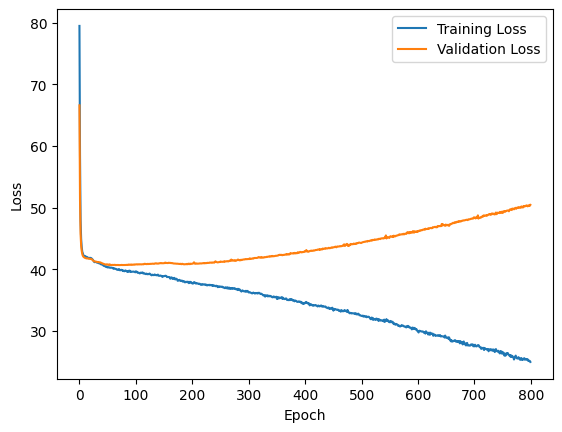

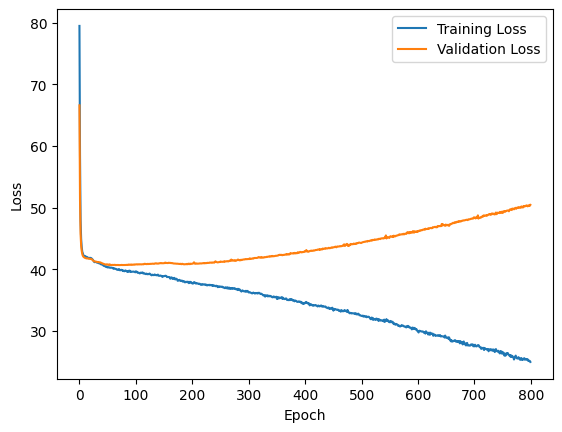

In [8]:
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)

train_utils.train_loop(
    train_loader=train_loader,
    val_loader=val_loader,
    model=model,
    criterion=criterion,
    device=device,
    optimizer=optimizer,
    epochs=epoch,
    save_path=save_path,
    scheduler=None
)

In [9]:
model.eval()
with torch.no_grad():
    recon = model(train_data.to(device))

criterion(train_data.to(device), recon, model.z) / 800 / 77

tensor(0.3251, device='cuda:0')